# RAG Beyond Basics: Chat with your Documents

Welcome to **RAG Beyond Basics**! This tutorial progressively introduces you to advanced Retrieval-Augmented Generation (RAG) techniques. You'll start with the fundamentals and gradually build up to sophisticated retrieval methods.

### What You'll Learn

This course is structured as a **progressive tutorial** that builds upon itself:

1. **Section 1: End-to-End RAG Pipeline** - Master the fundamentals
   - Document loading and preprocessing
   - Text chunking strategies
   - Embedding models and vector stores
   - Building your first RAG system

2. **Section 2: Reranking** - Improve retrieval quality
   - Why reranking matters
   - Multiple reranking approaches (GPT-4, ColBERT, Cohere)
   - Trade-offs and performance considerations

3. **Section 3: Query Expansion** - Better query understanding
   - Multi-query retrieval
   - Generating diverse query perspectives

4. **Section 4: Hypothetical Document Embeddings (HyDE)** - Advanced query representation
   - Generating hypothetical answers
   - Using LLM-generated embeddings for retrieval

5. **Section 5: Hybrid Search / Fusion Retriever** - Combining multiple search strategies
   - Semantic + keyword search
   - Weighted ensemble methods

6. **Section 6: Parent Document Retriever** - Context expansion
   - Retrieving full documents from chunk matches
   - Balancing precision and context

### Tools & Technologies Used

- **Document Loading**: PyMuPDF (fast), Docling (structure-preserving), UnstructuredIO (comprehensive)
- **Embedding Models**: HuggingFace BGE models (BAAI/bge-small-en-v1.5),
- **LLMs**: IBM Granite (via watsonx Platform)
- **Vector Store**: ChromaDB (lightweight, easy-to-use)
- **Framework**: LangChain (orchestration and pipeline creation)


### How to Use This Tutorial

1. **Run cells sequentially** - Each section builds on the previous one
2. **Read the documentation** - Extensive explanations are provided for each concept
3. **Experiment** - Try different parameters and see how they affect results
4. **Understand the "why"** - We explain not just what we do, but why we do it

### Prerequisites

- Basic Python knowledge
- Understanding of machine learning concepts (embeddings, similarity search)
- Familiarity with Jupyter notebooks

---


## SECTION 1: End-to-End RAG Pipeline

In this section, you'll learn how to build a complete RAG system from scratch. We'll cover:

1. Loading PDF documents
2. Splitting documents into chunks
3. Creating embeddings
4. Building a vector store
5. Retrieving relevant context
6. Generating answers using an LLM

**Why Start Here?** Understanding the basic RAG pipeline is crucial - all advanced techniques build upon these fundamentals.

In [ ]:
%pip install \
langchain>=0.3.0 \
langchain-community>=0.3.0 \
langchain-core>=0.3.0 \
langchain-ibm>=0.1.0 \
langchain-openai>=0.2.0 \
langchain-text-splitters>=0.3.0 \
loguru \
rich \
sentence-transformers==2.3.0 \
unstructured \
"unstructured[pdf]" \
chromadb \
rank_bm25 \
matplotlib \
jsonargparse \
pymupdf \
streamlit \
cohere \
docling langchain-ibm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
google-adk 1.17.0 requires opentelemetry-api<=1.37.0,>=1.37.0, but you have opentelemetry-api 1.38.0 which is incompatible.
google-adk 1.17.0 requires opentelemetry-sdk<=1.37.0,>=1.37.0, but you have opentelemetry-sdk 1.38.0 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.37.0 requires opentelemetry-exporter-otlp-proto-common==1.37.0, but you have opentelemetry-exporter-otlp-proto-common 1.38.0 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.37.0 requires opentelemetry-proto==1.37.0, but you have opentelemetry-proto 1.38.0 which is incompatible.
opentelemetry-exporter-otlp-proto-http 1.37.0 requires opentelemetry-sdk~=1.37.0, but you have opentelemetry-sdk 1.38.0 which is incompatible.


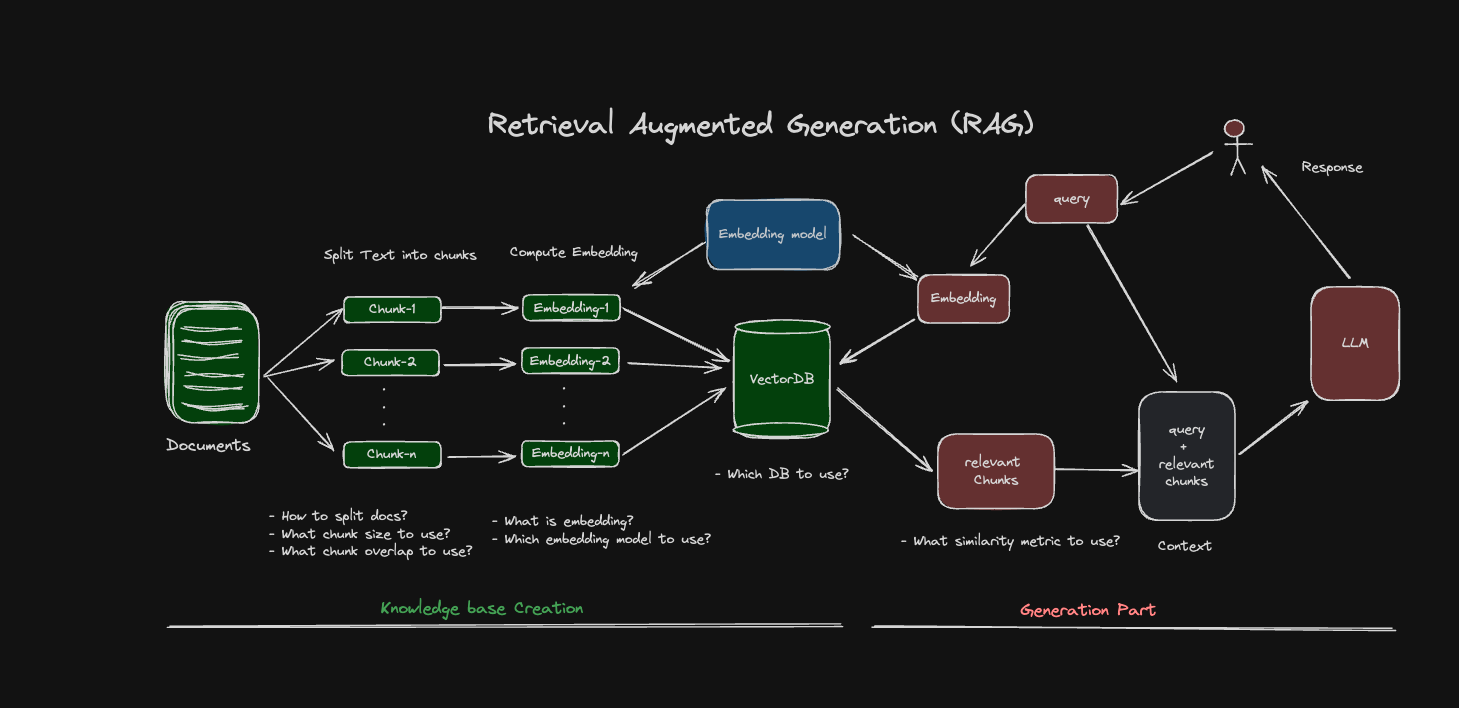

---

## 🔑 IBM watsonx Platform API Setup

### **How to Get Your IBM watsonx API Credentials**

To use IBM Granite models, you need:

1. **IBM Cloud Account**: Sign up at [https://cloud.ibm.com](https://cloud.ibm.com)
2. **watsonx Platform Access**:
   - Navigate to [IBM watsonx Platform](https://www.ibm.com/products/watsonx-platform)
   - Sign up for access (may require approval for some regions)

3. **⚠️ CRITICAL: Create a watsonx.ai Service Instance**
   - Go to [IBM Cloud Catalog](https://cloud.ibm.com/catalog)
   - Search for **"watsonx.ai"** and create a service instance
   - Choose **Lite Plan** (free tier) for testing
   - Select your region (note this - it will be your WATSONX_URL region)
   - Click **"Create"** and wait for provisioning (~1-2 minutes)
   
4. **Create a Project** (if you don't have one):
   - Go to your watsonx Platform dashboard
   - Click **"Create Project"**
   - **IMPORTANT:** During creation, **associate it with your watsonx.ai service instance**
   - Give it a name and create
   
   **OR if you already have a project:**
   - Open your project → **Settings** → **Service instance**
   - **Associate** your watsonx.ai service instance with the project
   - This step is REQUIRED - without it, you'll get "403 - project not associated with WML instance" errors
   
4a. **Find Your Project ID** (if you already have a project):
   
   **Method 1: From Browser URL (Easiest)**
   - Go to [IBM watsonx Platform](https://dataplatform.cloud.ibm.com)
   - Click **"Projects"** in the left sidebar
   - Click on your project name
   - **Look at the URL in your browser** - it contains your Project ID:
     ```
     https://dataplatform.cloud.ibm.com/projects/{YOUR_PROJECT_ID}/assets
     ```
     The Project ID is the long string between `/projects/` and the next `/`
     - Format: `xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx` (with hyphens)
   
   **Method 2: From Project Settings**
   - Open your project in watsonx Platform
   - Click **⚙️ Settings** or **"Settings"** tab
   - Look for **"Project Details"** or **"General Information"**
   - Find **"Project ID"**, **"GUID"**, or **"Instance ID"**
   - Copy the value
   
   **Method 3: Create New Project**
   - If you can't find your Project ID, create a new project
   - The Project ID will be shown immediately after creation

5. **Get API Key**:
   - Go to IBM Cloud dashboard
   - Navigate to **Identity & Access** → **Service IDs**
   - Create a new Service ID (if needed)
   - Generate an API Key
   - Save this key securely

### **Setting Up Credentials**

**For Google Colab:**
1. Go to **Secrets** (🔐) in the left sidebar
2. Add three secrets:
   - `watsonx_apikey`: Your IBM watsonx API key
   - `watsonx_project_id`: Your project ID
   - `watsonx_url`: Your regional endpoint URL (e.g., `https://us-south.ml.cloud.ibm.com`)

**For Local Environment:**
```bash
export WATSONX_APIKEY="your-api-key-here"
export WATSONX_PROJECT_ID="your-project-id-here"
export WATSONX_URL="https://us-south.ml.cloud.ibm.com"  # Or your region's URL
```

**Or in Python:**
```python
import os
os.environ["WATSONX_APIKEY"] = "your-api-key-here"
os.environ["WATSONX_PROJECT_ID"] = "your-project-id-here"
os.environ["WATSONX_URL"] = "https://us-south.ml.cloud.ibm.com"  # Or your region's URL
```

**Note about WATSONX_URL:**
- Required for connecting to watsonx Platform API
- Format: `https://{region}.ml.cloud.ibm.com`
- Common regions: `us-south` (Dallas), `eu-gb` (London), `eu-de` (Frankfurt), `jp-tok` (Tokyo)
- Defaults to `us-south` if not specified
- Match this to your project's region

### **Available Models**

**For Embeddings:**
- **Note:** IBM watsonx Platform does not currently provide embedding models via their API
- We use **HuggingFace BGE models** instead (free, high-quality, runs locally):
  - `BAAI/bge-small-en-v1.5` (default): Fast, 384 dims, good for most use cases
  - `BAAI/bge-base-en-v1.5`: Balanced, 768 dims
  - `BAAI/bge-large-en-v1.5`: Best quality, 1024 dims, slower

**For LLM (Text Generation) - IBM Granite via watsonx:**
- `ibm/granite-13b-instruct-v2` (13B parameters, recommended)
- `ibm/granite-8b-instruct-v2` (8B parameters, faster)
- `ibm/granite-34b-instruct-v2` (34B parameters, highest quality)

### **Links:**
- [IBM watsonx Platform](https://www.ibm.com/products/watsonx-platform)
- [IBM Cloud Console](https://cloud.ibm.com)
- [Granite Models Documentation](https://www.ibm.com/us-en/granite/docs/models)

---


In [ ]:
import os

from langchain_text_splitters import RecursiveCharacterTextSplitter
# from langchain_community.document_loaders import UnstructuredFileLoader
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
from rich import print

In [ ]:
if not os.path.exists("./data"):
  os.mkdir("./data")

In [ ]:
!wget https://arxiv.org/pdf/2306.02707.pdf -P ./data/


--2025-11-06 05:00:50--  https://arxiv.org/pdf/2306.02707.pdf
Resolving arxiv.org (arxiv.org)... 151.101.195.42, 151.101.67.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.195.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /pdf/2306.02707 [following]
--2025-11-06 05:00:50--  https://arxiv.org/pdf/2306.02707
Reusing existing connection to arxiv.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1458242 (1.4M) [application/pdf]
Saving to: ‘./data/2306.02707.pdf’

2306.02707.pdf      100%[===================>]   1.39M  --.-KB/s    in 0.07s   

2025-11-06 05:00:51 (20.6 MB/s) - ‘./data/2306.02707.pdf’ saved [1458242/1458242]



#### **📦 Installing Docling**

**What is Docling?**  
Docling is IBM's structure-preserving document converter. It's excellent for maintaining document hierarchy, tables, and formatting when converting PDFs to text.

**Key Features:**
- Preserves document structure (headers, sections, lists)
- Handles tables excellently
- Converts to clean markdown
- Good balance of speed and quality

**Installation:** Run the cell below to install Docling and its dependencies.

**Installation:**

Docling is available via pip and works on macOS, Linux, and Windows (both x86_64 and arm64).

**Note:** We'll install it in the next cell. Installation takes ~1-2 minutes and requires ~200MB of dependencies.

In [ ]:
# Install Docling with proper dependencies
# Note: Docling requires NumPy <2.0 for compatibility with some dependencies

# !pip install -q "numpy<2.0"
!pip install -q docling

# Verify installation
try:
    from docling.document_converter import DocumentConverter
    print("✅ Docling installed successfully!")
except ImportError as e:
    print(f"⚠️ Installation issue: {e}")
    print("If you see NumPy compatibility errors, restart the runtime and run this cell again.")

✅ Docling installed successfully!

In [ ]:
import fitz  # PyMuPDF
from langchain_core.documents import Document
from docling.document_converter import DocumentConverter

def load_pdf_docling(files="data/2306.02707.pdf"):
    """
    Loads documents from PDF files using Docling (structure-preserving parser).

    Parameters:
    - files: A string representing a single file path or a list of strings representing multiple file paths.

    Returns:
    - A list of Document objects loaded from the provided PDF files with structure preserved.

    Raises:
    - FileNotFoundError: If any of the provided file paths do not exist.
    - Exception: For any other issues encountered during file loading.
    """
    if not isinstance(files, list):
        files = [files]  # Ensure 'files' is always a list

    documents = []
    converter = DocumentConverter()

    for file_path in files:
        try:
            print(f"Converting {file_path} with Docling...")
            result = converter.convert(file_path)
            markdown_output = result.document.export_to_markdown()

            # Create a Document object
            document = Document(
                page_content=markdown_output,
                metadata={
                    "source": file_path,
                    "parser": "docling",
                    "num_pages": len(result.document.pages),
                    "num_tables": len(result.document.tables),
                    "structure_preserved": True
                }
            )
            documents.append(document)
            print(f"✅ Successfully converted {file_path}")
        except FileNotFoundError as e:
            print(f"File not found: {file_path}")
            raise
        except Exception as e:
            print(f"An error occurred while loading {file_path}: {e}")
            raise

    return documents

def load_pdf(files="data/2306.02707.pdf"):
    """
    Loads documents from PDF files using PyMuPDF.

    Parameters:
    - files: A string representing a single file path or a list of strings representing multiple file paths.

    Returns:
    - A list of Document objects loaded from the provided PDF files.

    Raises:
    - FileNotFoundError: If any of the provided file paths do not exist.
    - Exception: For any other issues encountered during file loading.

    The function applies post-processing steps such as cleaning extra whitespace and grouping broken paragraphs.
    """
    if not isinstance(files, list):
        files = [files]  # Ensure 'files' is always a list

    documents = []
    for file_path in files:
        try:
            # Open the PDF file
            doc = fitz.open(file_path)
            text = ""
            # Extract text from each page
            for page_num in range(len(doc)):
                page = doc.load_page(page_num)
                text += page.get_text("text")

            # Apply post-processing steps
            text = clean_extra_whitespace(text)
            text = group_broken_paragraphs(text)

            # Create a Document object
            document = Document(
                page_content=text,
                metadata={"source": file_path}
            )
            documents.append(document)
        except FileNotFoundError as e:
            print(f"File not found: {e.filename}")
            raise
        except Exception as e:
            print(f"An error occurred while loading {file_path}: {e}")
            raise

    return documents

def clean_extra_whitespace(text):
    """
    Cleans extra whitespace from the provided text.

    Parameters:
    - text: A string representing the text to be cleaned.

    Returns:
    - A string with extra whitespace removed.
    """
    return ' '.join(text.split())

def group_broken_paragraphs(text):
    """
    Groups broken paragraphs in the provided text.

    Parameters:
    - text: A string representing the text to be processed.

    Returns:
    - A string with broken paragraphs grouped.
    """
    return text.replace("\n", " ").replace("\r", " ")


In [ ]:
#data = load_pdf_docling("./data/2306.02707.pdf")

In [ ]:
data = load_pdf()

In [ ]:
print(data[0].page_content[:5000])

Orca: Progressive Learning from Complex Explanation Traces of GPT-4 Subhabrata Mukherjee∗†, Arindam Mitra∗ Ganesh 
Jawahar, Sahaj Agarwal, Hamid Palangi, Ahmed Awadallah Microsoft Research Abstract Recent research has focused on 
enhancing the capability of smaller models through imitation learning, drawing on the outputs generated by large 
foundation models (LFMs). A number of issues impact the quality of these models, ranging from limited imitation 
signals from shallow LFM outputs; small scale homogeneous training data; and most notably a lack of rigorous 
evaluation resulting in overestimating the small model’s capability as they tend to learn to imitate the style, but
not the reasoning process of LFMs. To address these challenges, we develop Orca, a 13-billion parameter model that 
learns to imitate the reasoning process of LFMs. Orca learns from rich signals from GPT-4 including explanation 
traces; step-by-step thought processes; and other complex instructions, guided by teacher assistance from ChatGPT. 
To promote this progressive learning, we tap into large-scale and diverse imitation data with judicious sampling 
and selection. Orca surpasses conventional state-of-the-art instruction-tuned models such as Vicuna-13B by more 
than 100% in complex zero-shot reasoning benchmarks like Big- Bench Hard (BBH) and 42% on AGIEval. Moreover, Orca 
reaches parity with ChatGPT on the BBH benchmark and shows competitive performance (4 pts gap with optimized system
message) in professional and academic examinations like the SAT, LSAT, GRE, and GMAT, both in zero-shot settings 
without CoT; while trailing behind GPT-4. Our research indicates that learning from step-by-step explanations, 
whether these are generated by humans or more advanced AI models, is a promising direction to improve model 
capabilities and skills. ∗Co-primary authors. Author contributions listed at the end of the paper. †Correspondence 
to subhabrata.mukherjee@microsoft.com We are working with our legal team to publicly release a diff of the model 
weights in accordance with LLaMA’s release policy to be published at https://aka.ms/orca-lm. Work in progress. 
arXiv:2306.02707v1  5 Jun 2023 Contents 1 Introduction 4 1.1 Challenges with Existing Methods . . . . . . . . . . .
. . . . . . . . . . . . . 5 1.2 Key Contributions . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
6 2 Preliminaries 7 2.1 Instruction Tuning . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 2.2 
Role of System Instructions . . . . . . . . . . . . . . . . . . . . . . . . . . . . 7 3 Explanation Tuning 8 3.1 
Dataset Construction . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 8 3.1.1 System Messages . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . 9 3.1.2 Dataset Description and Sampling from the FLAN-v2 
Collection . . . 9 3.1.3 ChatGPT as Teaching Assistant . . . . . . . . . . . . . . . . . . . . . 12 3.2 Training . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 13 4 Experiment Setup 14 4.1 Baselines 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 14 4.2 Tasks . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . 15 4.2.1 Open-ended Generation Capabilities . . . . . . . .
. . . . . . . . . . . 15 4.2.2 Reasoning Capabilities . . . . . . . . . . . . . . . . . . . . . . . . . . . 16 5 
Evaluation for Open-ended Generation 17 6 Evaluation for Reasoning 17 6.1 AGIEval Results . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . 17 6.2 Big-Bench Hard Results . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . 20 7 Evaluation for Safety 23 7.1 Truthful Question Answering . . . . . . . . . . . . . . . . . . .
. . . . . . . . 23 7.2 Toxic Content Generation . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 26 7.3 
Note on Hallucination and Tool Augmented LFMs . . . . . . . . . . . . . . . 27 8 Limitations 28 9 Conclusi

#### **🔧 Basic Docling Usage**

**Simple PDF to Markdown Conversion:**

The basic workflow is straightforward:
1. Create a `DocumentConverter` instance
2. Call `convert()` with PDF path or URL
3. Export to Markdown with `export_to_markdown()`

**What Docling Does Internally:**
1. **Layout Analysis**: Identifies page regions (text, tables, figures, headers)
2. **Reading Order**: Determines correct flow of content (handles columns, sidebars)
3. **Table Detection**: Finds table boundaries and cell structure
4. **Structure Recovery**: Reconstructs hierarchy (headings, lists, paragraphs)
5. **Export**: Converts to clean, structured Markdown

Let's test it on our research paper!

---

In [ ]:
from docling.document_converter import DocumentConverter

# Create converter
converter = DocumentConverter()

# Convert our downloaded PDF
print("Converting PDF with Docling...")
print("This may take 30-60 seconds for a ~50 page document...")

result = converter.convert("./data/2306.02707.pdf")

print(f"✅ Conversion complete!")
print(f"Document has {len(result.document.pages)} pages")

Converting PDF with Docling...

This may take 30-60 seconds for a ~50 page document...

[INFO] 2025-11-06 05:01:31,552 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-06 05:01:31,570 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-11-06 05:01:31,571 [RapidOCR] main.py:53: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-11-06 05:01:31,640 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-06 05:01:31,644 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-11-06 05:01:31,644 [RapidOCR] main.py:53: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-11-06 05:01:31,681 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-06 05:01:31,713 [RapidOCR] download_file.py:60: File exists and is valid: /usr/loc

✅ Conversion complete!

Document has 51 pages

### SECTION 1.2: Splitting Documents into Chunks

**What You'll Learn:**
- Why chunking is critical for RAG systems
- Different chunking strategies
- How chunk size and overlap affect retrieval quality

**Why Chunking Matters:**
LLMs have **limited context windows** (typically 4K-128K tokens). You can't feed entire documents to the LLM, so you must:
1. Split documents into smaller "chunks"
2. Embed each chunk
3. Retrieve the most relevant chunks for each query
4. Pass only those chunks (plus the query) to the LLM

**Chunking Trade-offs:**

| Aspect | Small Chunks | Large Chunks |
|--------|--------------|--------------|
| **Precision** | Higher (more focused) | Lower (may contain irrelevant info) |
| **Context** | Less context per chunk | More context per chunk |
| **Retrieval** | More precise matches | May miss important context |
| **Cost** | More chunks = more embeddings | Fewer chunks = fewer embeddings |

**Key Parameters:**
- **chunk_size**: Maximum characters per chunk (typical: 500-2000)
- **chunk_overlap**: Characters to overlap between chunks (typical: 50-200)
  - Overlap prevents losing context at chunk boundaries
  - Example: If chunk 1 ends with "the cat sat on the" and chunk 2 starts with "mat", you might miss that they're part of the same sentence

**Best Practices:**
- Start with chunk_size=1000, chunk_overlap=200
- Adjust based on your documents:
  - Short, focused documents → smaller chunks
  - Long, complex documents → larger chunks with more overlap

---



#### Introduction
Here, we divide the documents from our knowledge base into smaller sections/chunks, which will act as the basis for the reader LLM's responses.

The objective is to create a collection of semantically relevant snippets. The size of these snippets is crucial: too small, and they may cut off ideas; too large, and they could dilute the concepts.

### Recursive Chunking Method

**What is RecursiveCharacterTextSplitter?**

This is LangChain's smart chunking strategy that:
1. **Tries to split on natural boundaries first** (paragraphs, sentences, words)
2. **Falls back to character-level splitting** if chunks are still too large
3. **Maintains overlap** between chunks to preserve context

**Why "Recursive"?**
It recursively tries different separators in order of preference:
1. Paragraphs (`\n\n`)
2. Single newlines (`\n`)
3. Sentences (`. `)
4. Words (` `)
5. Characters (if nothing else works)

**Advantages:**
- ✅ Preserves semantic boundaries when possible
- ✅ Handles documents of varying structure
- ✅ Ensures chunks never exceed size limit
- ✅ Maintains overlap for context preservation

**Example:**
If you have a document with sections separated by double newlines, it will split at those boundaries first, keeping each section as a cohesive chunk.

#### Overview
The Recursive Chunking Method systematically divides text into increasingly smaller sections by applying a hierarchy of separators. This approach ensures a step-by-step breakdown, preserving the text's overall structure while accommodating size variations in the resulting chunks.

#### How It Works
Given a list of separators arranged by their significance (e.g., `["\n\n", "\n", ".", ""]`), the process unfolds as follows:

1. **Initial Split**: Begin by dividing the document at every occurrence of the most significant separator (`"\n\n"`).
2. **Further Splits**: Subsequent divisions are made using the next separator in the list (`"\n"`), followed by sentence terminators (`"."`).
3. **Size Adjustment**: If chunks still exceed the maximum allowable size, they are further split, ensuring they fit the size criteria.

#### Outcome
This method maintains the document's overarching structure, even though chunk sizes may vary slightly due to the recursive splitting process.


In [ ]:
from langchain_core.documents import Document

# Export to markdown
markdown_output = result.document.export_to_markdown()

# Create a Document object from Docling output
docling_document = Document(
    page_content=markdown_output,
    metadata={
        "source": "./data/2306.02707.pdf",
        "parser": "docling",
        "num_pages": len(result.document.pages),
        "num_tables": len(result.document.tables),
        "structure_preserved": True
    }
)

print("✅ Created LangChain Document from Docling output")
print()
print("Document Metadata:")
for key, value in docling_document.metadata.items():
    print(f"  {key}: {value}")
print()
print(f"Content length: {len(docling_document.page_content):,} characters")
print()

✅ Created LangChain Document from Docling output

Document Metadata:

source: ./data/2306.02707.pdf

parser: docling

num_pages: 51

num_tables: 12

structure_preserved: True

Content length: 133,115 characters

In [ ]:
# split_documents_into_chunks()
# Ensure documents is a list (required for iteration)
documents = [docling_document] if not isinstance(docling_document, list) else docling_document

from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2500,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
)

docs_processed = []
for doc in documents:
    docs_processed += text_splitter.split_documents([doc])

#### SECTION 1.4: The Embedding Model

**What You'll Learn:**
- What embeddings are and why they're crucial
- Different embedding models and their trade-offs
- How to choose the right model for your use case

**What are Embeddings?**
Embeddings are **vector representations of text** that capture semantic meaning. Similar text should have similar embeddings (measured by cosine similarity or dot product).

**Why Embeddings Matter:**
1. **Semantic Search**: Find documents by meaning, not just keywords
2. **Context Understanding**: The model understands relationships between concepts
3. **Retrieval Quality**: Better embeddings = better retrieval = better answers

**Model Options:**

1. **BAAI/bge-small-en-v1.5** (default, used here)
   - ✅ Fast and efficient (384 dimensions)
   - ✅ Good quality for most tasks
   - ✅ Free, runs locally
   - ✅ Small model size (~130MB)
   - Best for: General use, large document collections, real-time applications

2. **BAAI/bge-base-en-v1.5**
   - ✅ Better quality than small (768 dimensions)
   - ✅ Still reasonably fast
   - ❌ Larger model size (~420MB)
   - Best for: Higher quality needs, smaller collections

3. **BAAI/bge-large-en-v1.5**
   - ✅ Best quality (1024 dimensions)
   - ❌ Slower and larger (~1.3GB)
   - Best for: Critical applications where quality is paramount

**How It Works:**
1. Text → Tokenization → Model → Vector (embedding)
2. Chunks are embedded during indexing
3. Queries are embedded during retrieval
4. Similarity search finds closest chunk vectors

In [ ]:
from sentence_transformers import SentenceTransformer
from langchain_core.embeddings import Embeddings
import torch
import numpy as np
from typing import List, Union
import os

# Note: IBM watsonx Platform does not currently offer embedding models via their API.
# We'll use HuggingFace BGE embeddings directly via sentence-transformers, which provides
# excellent quality and are free to use. These models run locally and don't require API calls.

class BGEEmbeddings(Embeddings):
    """Custom embedding class that wraps SentenceTransformer for BGE models."""

    def __init__(self, model_name: str, device: str = None, normalize: bool = True):
        """
        Initialize BGE embeddings.

        Args:
            model_name: HuggingFace model name (e.g., "BAAI/bge-small-en-v1.5")
            device: Device to use ("cpu", "cuda", "mps"). If None, auto-detects.
            normalize: Whether to normalize embeddings (recommended for cosine similarity)
        """
        self.model_name = model_name
        self.normalize = normalize

        # Auto-detect device if not specified
        if device is None:
            if torch.backends.mps.is_available():
                device = "mps"
            elif torch.cuda.is_available():
                device = "cuda"
            else:
                device = "cpu"

        self.device = device
        print(f"Loading embedding model: {model_name} on {device}...")

        # Load SentenceTransformer model directly (bypasses LangChain compatibility issues)
        self.model = SentenceTransformer(model_name, device=device)

        print(f"✅ Loaded embedding model: {model_name}")
        print(f"📍 Device: {device}")

        # Test to get dimension
        test_emb = self.embed_query("test")
        print(f"📊 Embedding dimension: {len(test_emb)}")

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed a list of documents."""
        embeddings = self.model.encode(
            texts,
            normalize_embeddings=self.normalize,
            convert_to_numpy=True
        )
        # Convert NumPy array to native Python list
        if isinstance(embeddings, np.ndarray):
            return embeddings.tolist()
        return [[float(x) for x in emb] for emb in embeddings]

    def embed_query(self, text: str) -> List[float]:
        """Embed a single query."""
        embedding = self.model.encode(
            text,
            normalize_embeddings=self.normalize,
            convert_to_numpy=True
        )
        # Ensure native Python types (fixes ChromaDB NumPy compatibility)
        return [float(x) for x in embedding.tolist()]
def load_embedding_model(
    model_name = "BAAI/bge-small-en-v1.5",
    device = None
):
    """
    Loads a HuggingFace BGE Embedding model for text embeddings.

    Note: IBM watsonx Platform does not currently provide embedding models via API.
    Using HuggingFace BGE models which are state-of-the-art and free.

    Parameters:
    - model_name: The HuggingFace model name. Options:
        - "BAAI/bge-small-en-v1.5" (default): Fast, 384 dimensions, 33M params - good for most use cases
        - "BAAI/bge-base-en-v1.5": Balanced, 768 dimensions, 110M params
        - "BAAI/bge-large-en-v1.5": Best quality, 1024 dimensions, 335M params - slower but more accurate
    - device: Device to run on ("cpu", "cuda", "mps"). If None, auto-detects.

    Returns:
    - An instance of BGEEmbeddings configured with the specified model.

    Raises:
    - Exception: For any issues encountered during model loading.
    """
    try:
        embedding_model = BGEEmbeddings(
            model_name=model_name,
            device=device,
            normalize=True  # Important for cosine similarity
        )
        return embedding_model
    except Exception as e:
        print(f"❌ Error loading embedding model: {e}")
        print("💡 Tip: Make sure you have sentence-transformers installed: pip install sentence-transformers")
        raise


In [ ]:
embedding_model = load_embedding_model()

Loading embedding model: BAAI/bge-small-en-v1.5 on cuda...

✅ Loaded embedding model: BAAI/bge-small-en-v1.5

📍 Device: cuda

📊 Embedding dimension: 384

### Vector Store

**What is a Vector Store?**

A vector store is a **specialized database** optimized for similarity search. Instead of traditional database queries (e.g., "WHERE name='John'"), vector stores allow queries like "find the 5 most similar vectors to this query vector."

**How It Works:**
1. **Indexing**: Each document chunk is converted to an embedding (vector) and stored
2. **Search**: When you query, your query is also embedded
3. **Similarity**: The vector store finds chunks whose embeddings are most similar to your query embedding
4. **Retrieval**: Returns the top-k most similar chunks

**Why ChromaDB?**
- ✅ **Easy Setup**: No separate server, works in-process
- ✅ **Fast**: Efficient similarity search algorithms
- ✅ **Persistent**: Can save to disk for reuse
- ✅ **Free**: Open-source, no costs
- ✅ **Flexible**: Supports metadata filtering

**Alternatives:**
- **Pinecone**: Managed cloud service, very scalable
- **Weaviate**: Feature-rich, supports hybrid search
- **FAISS**: Facebook's library, extremely fast
- **Qdrant**: Modern, production-ready, good performance

**Key Concepts:**
- **Collection**: A named group of embeddings (like a table)
- **Metadata**: Additional data stored with each chunk (source, page number, etc.)
- **top_k**: Number of most similar chunks to retrieve

In [ ]:
from langchain_community.vectorstores import Chroma
import uuid

def get_retriever(docs, embedding_model, top_k=5, collection_name=None):
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.
    - collection_name: (Optional) Unique name for ChromaDB collection. If None, generates a unique name.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        # Use unique collection name to prevent duplicates
        if collection_name is None:
            collection_name = f"rag_collection_{uuid.uuid4().hex[:8]}"

        vector_store = Chroma.from_documents(
                docs,
                embedding_model,
                collection_name=collection_name
            )

        retriever = vector_store.as_retriever(k=top_k)
        # retriever.k = top_k

        return retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise


In [ ]:
retriever = get_retriever(docs_processed, embedding_model, top_k=5, collection_name="instruction_tuning_chunks")


In [ ]:
# Use invoke with 'input' parameter for newer LangChain versions
similar_chunks = retriever.invoke("What is instruction tuning?")
# Alternatively, you can use: similar_chunks = retriever.get_relevant_documents("What is instruction tuning?")
similar_chunks

[Document(metadata={'structure_preserved': True, 'num_tables': 12, 'start_index': 19298, 'parser': 'docling', 'source': './data/2306.02707.pdf', 'num_pages': 51}, page_content='| Model                             | Tuning Method                                                                                                                                                        | Data Size           | Teacher                                                           |\n|-----------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------|\n| Alpaca Vicuna Dolly WizardLM Orca | Simple Instructions / Self-instruct User Instructions / Natural User Instructions / Natural Complex Instructions / Evol-instruct Complex Instructions / Explanations | 52K 70K 15K 250K 5M | text

In [ ]:
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content)
    print(f"-----------------------------------------------------------------------------------\n")

--------------------------------- chunk # 0 -------------------------------------

| Model                             | Tuning Method                                                                
| Data Size           | Teacher                                                           |
|-----------------------------------|------------------------------------------------------------------------------
----------------------------------------------------------------------------------------|---------------------|----
---------------------------------------------------------------|
| Alpaca Vicuna Dolly WizardLM Orca | Simple Instructions / Self-instruct User Instructions / Natural User 
Instructions / Natural Complex Instructions / Evol-instruct Complex Instructions / Explanations | 52K 70K 15K 250K 
5M | text-da-vinci-003 ChatGPT Human ChatGPT ChatGPT (5M) ∩ GPT-4 (1M) |

Figure 4: Instruction-tuning with GPT-4 9 . Given user instructions for a task and an input, the system generates a
response. Existing works like Alpaca [7], Vicuna [9] and variants follow a similar template to train small models 
with 〈 {user instruction, input}, output 〉 .

<!-- image -->

## 2 Preliminaries

## 2.1 Instruction Tuning

Instruction tuning [22] is a technique that allows pre-trained language models to learn from input (natural 
language descriptions of the task) and response pairs, for example, {"instruction": "Arrange the words in the given
sentence to form a grammatically correct sentence.", "input": "the quickly brown fox jumped", "output": "the brown 
fox jumped quickly"} . Instruction tuning has been applied to both language-only and multimodal tasks. For 
language-only tasks, instruction tuning has been shown to improve the zero-shot and few-shot performance of models 
such as FLAN [22] and InstructGPT [5] on various benchmarks. For multimodal tasks, instruction tuning has been used
to generate synthetic instruction-following data for language-image tasks, such as image captioning [23] and visual
question answering [24].

-----------------------------------------------------------------------------------

--------------------------------- chunk # 1 -------------------------------------

A wide range of works in recent times, including Alpaca [7], Vicuna [9], WizardLM [8] and Koala [14], have adopted 
instruction-tuning to train smaller language models with outputs generated from large foundation models from the 
GPT family. As outlined in Section 1.1, a significant drawback with all these works has been both limited task 
diversity, query complexity and small-scale training data in addition to limited evaluation overstating the 
benefits of such approach.

## 2.2 Role of System Instructions

Vanilla instruction-tuning (refer to Figure 4 for examples) often uses input, response pairs with short and terse 
responses. Such responses when used to train smaller models, as in existing works, give them limited ability to 
trace the reasoning process of the LFM. In constrast, system instructions 10 in recent LFMs like GPT-4 can be used 
to provide guidance

9 GPT-4 inference hyper-parameters in Azure OpenAI interface set as: temperature=0.7, top\_p=0.95, 
frequency\_penalty=0, presence\_penalty=0, stop=None.

10 System instructions are part of the Chat Completion API, which is a new dedicated API for interacting with the 
ChatGPT and GPT-4 models.

Figure 5: Explanation-tuning with GPT-4. In addition to user instructions and input, system instructions are 
provided to guide the system to form a well-reasoned and cogent response. System instructions are sampled from a 
diverse instruction set including chain-of-thought reasoning steps, explain like I'm five, being helpful and 
informative, etc. Such rich and well-structured response allows tuning small models to mimic the thinking process 
of GPT-4 on 〈 {system instruction, user instruction, input}, output 〉 pairs.

<!-- image -->

to the model on how to behave and respond. They are written in natural language and separated from the user 
messages by using the role of 'system' in the JSON request. System instructions can specify the tone, task, format,
and limitations of the model's responses. System instructions are also a way of improving the safety of model 
responses. For example, a set of system instructions designed for safety harness could be:

- The assistant must not generate harmful or offensive content.
- The assistant must respect the privacy and consent of the user.
- The assistant must acknowledge its limitations and uncertainties.

## 3 Explanation Tuning

-----------------------------------------------------------------------------------

--------------------------------- chunk # 2 -------------------------------------

In this research, our focus is on addressing the challenges mentioned above, specifically with:

Explanation tuning: We augment 〈 query, response 〉 pairs with detailed responses from GPT-4 that explain the 
reasoning process of the teacher as it generates the response. These provide the student with additional signals 
for learning. We leverage system instructions (e.g.., explain like I'm five, think step-by-step and justify your 
response , etc.) to elicit such explanations. This is in contrast to vanilla instruction tuning, which only uses 
the prompt and the LFM response for learning, providing little opportunity for mimicking the LFM's 'thought' 
process.

Scaling tasks and instructions: We utilize the Flan 2022 Collection [19] as it provides an extensive public 
assortment of tasks and instructions. Particularly, we use FLANv2, supplemented with high-quality templates, 
advanced formatting patterns, and data augmentations. Even though FLAN holds tens of millions of instructions, we 
selectively sample from the task collection to form a diverse mixture of tasks, which we then further sub-sample to
generate complex prompts. These prompts are used to query LFMs like ChatGPT and GPT-4, thus creating a rich and 
diverse training set. We collect 5 million ChatGPT responses, from which 1 million is further sampled to acquire 
GPT-4 responses. We demonstrate how ChatGPT as a teacher assistant helps in progressive learning.

Evaluation: We assess the generative, reasoning, and comprehension abilities of Orca, under a range of settings: 
(i) AutoEvaluation with GPT-4 on existing evaluation sets from Vicuna, WizardLM and the awesome prompts collection 
8 ; (ii) Academic benchmarks like Big-Bench Hard [4] and TruthfulQA [20]; (iii) Professional and Academic exams 
like SAT, LSAT, GRE, GMAT from AGIEval [1]; (iv) Safety evaluation with ToxiGen [21] to test toxic language 
generation and hate speech detection across different minority groups. Finally, we provide case-studies to compare 
the generation and reasoning abilities of Orca against OpenAI LFMs like ChatGPT and GPT-4, and instruction-tuned 
smaller model like Vicuna.

7 Note that OpenAI API's do give access to the top -5 logits for each token.

8 https://prompts.chat/

Table 1: Overview of popular models instruction tuned with OpenAI large foundation models (LFMs). Orca leverages 
complex instructions and explanations for progressive learning.

-----------------------------------------------------------------------------------

--------------------------------- chunk # 3 -------------------------------------

5 ChatGPT may have data contamination issues with respect to BigBench

6 https://sharegpt.com/

content generation and information-seeking queries over other types of tasks. Therefore, models trained on such 
natural conversations may capture the style but not the reasoning process of the LFMs - demonstrated in the 
performance of Vicuna in Figures 2 and 3. Additionally, such mode of data collection is also limited in scale. 
Table 1 shows an overview of the size of data and tuning methods employed in recent popular instruction tuning 
works.

Limited imitation signals. Existing methods rely on immitation learning from 〈 query, response 〉 pairs generated 
by the teacher model. However, this provides limited signals to trace the reasoning process of the teacher. Prior 
works [15, 16] on open-box model show that richer signals such as logits, intermediate representations and 
attention states can significantly improve distillation performance. While they are not accessible for closed-box 
LFM's 7 , recent work [17] demonstrates that richer signals like LFM rationales can help close the gap for 
task-specific distillation.

Evaluation: Previous studies on instruction tuning of small models with LFMs are severely limited in their 
evaluation protocol. They often rely on GPT-4 for auto-evaluation by asking it to compare the outputs of two 
systems with a prompt like 'given responses from system 1 (reference) and system 2 (target), which one is better?'.
However, this approach has several drawbacks, such as the small size of test sets (e.g., 80 instructions in Vicuna 
and 218 instructions in WizardLM) and the biases of GPT-4 as the judge [18]. For example, we notice that models 
that are instruction-tuned with GPT-4 responses tend to generate longer texts that GPT-4 prefers over shorter ones;
as well as GPT-4 has a bias in the order of the candidate responses. We will show that such auto-evaluation 
measures overestimate the abilities of smaller models compared to LFMs, as the former are much weaker in 
comprehension and reasoning skills.

## 1.2 Key Contributions

In this research, our focus is on addressing the challenges mentioned above, specifically with:

-----------------------------------------------------------------------------------

wrap everything in a function

In [ ]:
def retrieve_context(query, retriever, remove_duplicates=True):
    """
    Retrieves documents relevant to a given query using the retriever.

    Parameters:
    - query: The search query as a string.
    - retriever: An instance of a Retriever class used to fetch documents.
    - remove_duplicates: If True, removes duplicate chunks based on page_content. Defaults to True.

    Returns:
    - A list of Document objects relevant to the query (with duplicates removed if requested).

    Note:
    - ChromaDB retrievers expect query string directly, not a dictionary.
    - This function handles both newer (invoke) and older (get_relevant_documents) API formats.
    """
    # For ChromaDB retrievers, invoke expects query string directly (not dict)
    # Try the modern invoke() method first
    try:
        retrieved_docs = retriever.invoke(query)
    except (TypeError, KeyError, AttributeError) as e:
        # Fallback: use get_relevant_documents for compatibility with older LangChain versions
        if hasattr(retriever, 'get_relevant_documents'):
            retrieved_docs = retriever.get_relevant_documents(query)
        else:
            # Last resort: re-raise the original error
            raise ValueError(f"Retriever does not support invoke() or get_relevant_documents(): {e}")

    # Remove duplicates if requested (based on content hash)
    if remove_duplicates and retrieved_docs:
        seen_content = set()
        unique_docs = []

        for doc in retrieved_docs:
            # Use hash of page_content as unique identifier
            content_hash = hash(doc.page_content)
            if content_hash not in seen_content:
                seen_content.add(content_hash)
                unique_docs.append(doc)

        if len(unique_docs) < len(retrieved_docs):
            print(f"Removed {len(retrieved_docs) - len(unique_docs)} duplicate chunk(s)")

        return unique_docs

    return retrieved_docs

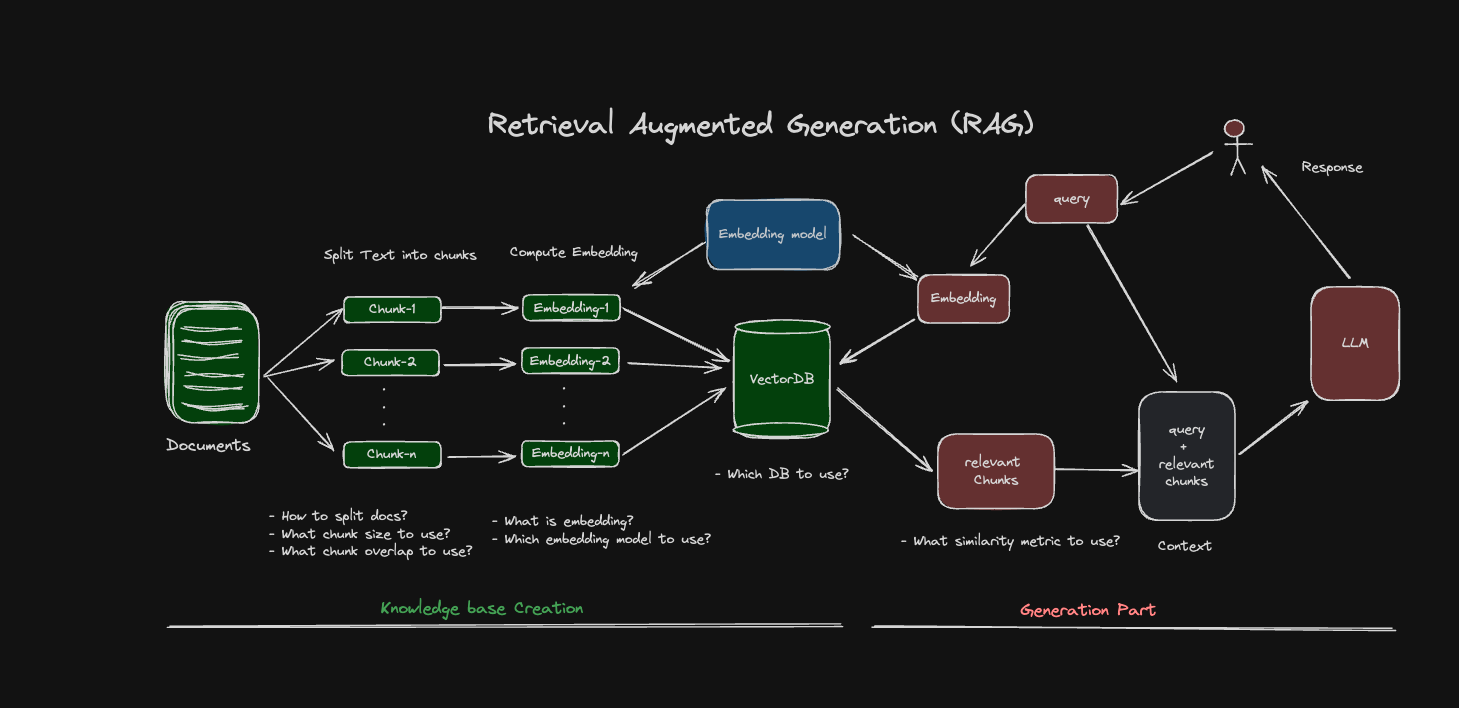

### SECTION 1.5: Putting Everything Together - Building Your First RAG Pipeline

**What You'll Learn:**
- How to assemble all components into a working RAG system
- Querying your document collection
- Generating answers with an LLM

**The Complete RAG Flow:**

```
Document → Chunking → Embedding → Vector Store
                                            ↓
Query → Embedding → Similarity Search → Top-k Chunks → LLM → Answer
```

**What Happens:**
1. **Document Processing**: PDF loaded and chunked
2. **Indexing**: Chunks embedded and stored in vector database
3. **Query**: User asks a question
4. **Retrieval**: System finds most relevant chunks
5. **Generation**: LLM generates answer based on retrieved context

**Key Components:**
- **Retriever**: Handles similarity search (finds relevant chunks)
- **Prompt Template**: Structures the query + context for the LLM
- **LLM Chain**: Orchestrates retrieval → prompt → generation

**Why This Structure?**
- **Separation of Concerns**: Each component does one thing well
- **Modularity**: Easy to swap models, retrievers, or LLMs
- **Testability**: Can test each component independently

In [ ]:
from langchain_ibm import ChatWatsonx
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

### Using IBM watsonx Platform API

Moving forward, we will be using IBM Granite LLM and Embedding models via the watsonx Platform API.

In [ ]:
from google.colab import userdata
os.environ["WATSONX_APIKEY"] = userdata.get('WATSONX_APIKEY')
os.environ["WATSONX_PROJECT_ID"] = userdata.get('WATSONX_PROJECT_ID')
# os.getenv("WATSONX_URL") = userdata.get('WATSONX_URL')
project_id = os.getenv("WATSONX_PROJECT_ID")

In [ ]:
# Initialize IBM Granite LLM via watsonx Platform API
# Available Granite models: ibm/granite-13b-instruct-v2, ibm/granite-8b-instruct-v2, etc.
llm = ChatWatsonx(
    model_id="ibm/granite-3-2-8b-instruct",
    project_id=os.getenv("WATSONX_PROJECT_ID"),
    url=os.getenv("WATSONX_URL", "https://us-south.ml.cloud.ibm.com"),
    temperature=0
)
prompt_template = ChatPromptTemplate.from_template(
        (
            "Please answer the following question based on the provided `context` that follows the question.\n"
            "If you do not know the answer then just say 'I do not know'\n"
            "question: {question}\n"
            "context: ```{context}```\n"
        )
    )

In [ ]:
chain = prompt_template | llm | StrOutputParser()

In [ ]:
query = "What is instruction tuninig?"

context = retrieve_context(
        query, retriever=retriever,
    )

In [ ]:
context

[Document(metadata={'start_index': 21342, 'num_pages': 51, 'structure_preserved': True, 'source': './data/2306.02707.pdf', 'parser': 'docling', 'num_tables': 12}, page_content="A wide range of works in recent times, including Alpaca [7], Vicuna [9], WizardLM [8] and Koala [14], have adopted instruction-tuning to train smaller language models with outputs generated from large foundation models from the GPT family. As outlined in Section 1.1, a significant drawback with all these works has been both limited task diversity, query complexity and small-scale training data in addition to limited evaluation overstating the benefits of such approach.\n\n## 2.2 Role of System Instructions\n\nVanilla instruction-tuning (refer to Figure 4 for examples) often uses input, response pairs with short and terse responses. Such responses when used to train smaller models, as in existing works, give them limited ability to trace the reasoning process of the LFM. In constrast, system instructions 10 in re

In [ ]:
text = ""
for ch in context:
    text += ch.page_content

In [ ]:
print(text)


A wide range of works in recent times, including Alpaca [7], Vicuna [9], WizardLM [8] and Koala [14], have adopted 
instruction-tuning to train smaller language models with outputs generated from large foundation models from the 
GPT family. As outlined in Section 1.1, a significant drawback with all these works has been both limited task 
diversity, query complexity and small-scale training data in addition to limited evaluation overstating the 
benefits of such approach.

## 2.2 Role of System Instructions

Vanilla instruction-tuning (refer to Figure 4 for examples) often uses input, response pairs with short and terse 
responses. Such responses when used to train smaller models, as in existing works, give them limited ability to 
trace the reasoning process of the LFM. In constrast, system instructions 10 in recent LFMs like GPT-4 can be used 
to provide guidance

9 GPT-4 inference hyper-parameters in Azure OpenAI interface set as: temperature=0.7, top\_p=0.95, 
frequency\_penalty=0, presence\_penalty=0, stop=None.

10 System instructions are part of the Chat Completion API, which is a new dedicated API for interacting with the 
ChatGPT and GPT-4 models.

Figure 5: Explanation-tuning with GPT-4. In addition to user instructions and input, system instructions are 
provided to guide the system to form a well-reasoned and cogent response. System instructions are sampled from a 
diverse instruction set including chain-of-thought reasoning steps, explain like I'm five, being helpful and 
informative, etc. Such rich and well-structured response allows tuning small models to mimic the thinking process 
of GPT-4 on 〈 {system instruction, user instruction, input}, output 〉 pairs.

<!-- image -->

to the model on how to behave and respond. They are written in natural language and separated from the user 
messages by using the role of 'system' in the JSON request. System instructions can specify the tone, task, format,
and limitations of the model's responses. System instructions are also a way of improving the safety of model 
responses. For example, a set of system instructions designed for safety harness could be:

- The assistant must not generate harmful or offensive content.
- The assistant must respect the privacy and consent of the user.
- The assistant must acknowledge its limitations and uncertainties.

## 3 Explanation Tuning| Model                             | Tuning Method                                         
| Data Size           | Teacher                                                           |
|-----------------------------------|------------------------------------------------------------------------------
----------------------------------------------------------------------------------------|---------------------|----
---------------------------------------------------------------|
| Alpaca Vicuna Dolly WizardLM Orca | Simple Instructions / Self-instruct User Instructions / Natural User 
Instructions / Natural Complex Instructions / Evol-instruct Complex Instructions / Explanations | 52K 70K 15K 250K 
5M | text-da-vinci-003 ChatGPT Human ChatGPT ChatGPT (5M) ∩ GPT-4 (1M) |

Figure 4: Instruction-tuning with GPT-4 9 . Given user instructions for a task and an input, the system generates a
response. Existing works like Alpaca [7], Vicuna [9] and variants follow a similar template to train small models 
with 〈 {user instruction, input}, output 〉 .

<!-- image -->

## 2 Preliminaries

## 2.1 Instruction Tuning

Instruction tuning [22] is a technique that allows pre-trained language models to learn from input (natural 
language descriptions of the task) and response pairs, for example, {"instruction": "Arrange the words in the given
sentence to form a grammatically correct sentence.", "input": "the quickly brown fox jumped", "output": "the brown 
fox jumped quickly"} . Instruction tuning has been applied to both language-only and multimodal tasks. For 
language-only tasks, instruction tuning has been shown to imp

In [ ]:
response = chain.invoke({"context": context, "question": query})

In [ ]:
print(response)

Instruction tuning is a technique that enables pre-trained language models to learn from input-response pairs, 
where the input is a natural language description of a task and the response is the desired output. This method has
been applied to both language-only and multimodal tasks. For language-only tasks, instruction tuning has improved 
the zero-shot and few-shot performance of models like FLAN and InstructGPT. For multimodal tasks, it has been used 
to generate synthetic instruction-following data for tasks such as image captioning and visual question answering. 
In the context provided, it's mentioned that recent works like Alpaca, Vicuna, and WizardLM have adopted 
instruction-tuning to train smaller language models using outputs generated from large foundation models from the 
GPT family.

In [ ]:
query = "How does Orca model compares to ChatGPT?"

context = retrieve_context(
        query, retriever=retriever,
    )
response = chain.invoke({"context": context, "question": query})
print(response)

According to the provided context, Orca performs at par with Text-da-Vinci-003 and retains 88% of ChatGPT quality 
on an aggregate across all tasks. However, it significantly lags behind GPT-4. When compared to ChatGPT, Orca 
demonstrates stronger performance in certain areas such as entailment and semantic understanding tasks, showing a 
4.5% improvement over ChatGPT in formal fallacies tasks. 

In terms of numerical performance, Orca beats ChatGPT in 325 examples across different tasks, while ChatGPT beats 
Orca in 450 examples. Orca's performance varies significantly based on the type of system message used. 

In the Big-Bench Hard benchmark, Orca performs marginally better than ChatGPT on aggregate but lags significantly 
behind GPT-4, with a 26% performance gap. Despite this, Orca outperforms Vicuna by 113% in this benchmark. 

In summary, while Orca performs comparably to ChatGPT in many aspects and even surpasses it in certain tasks, it 
generally falls short of GPT-4's capabilities.

In [ ]:
query = "What is the diameter of the sun?"

context = retrieve_context(
        query, retriever=retriever,
    )

response = chain.invoke({"context": context, "question": query})
print(response)

The context does not provide information on the diameter of the sun.

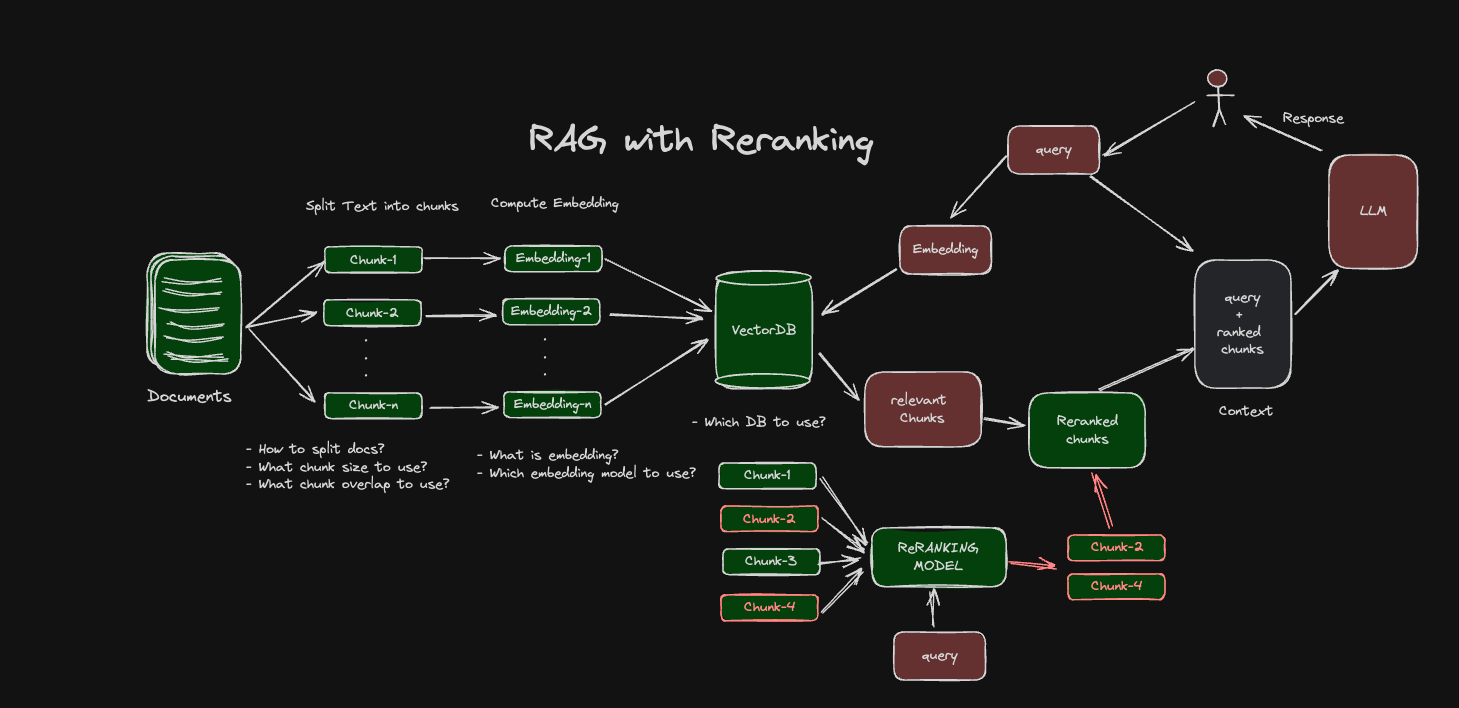

---

## 🎯 SECTION 2: RERANKING - Improving Retrieval Quality

### Why Reranking?

**The Problem with Simple Retrieval:**
- Embedding-based search: Fast but sometimes misses nuances
- Top-K results: May include some irrelevant chunks
- Single-stage retrieval: Cannot capture complex query-document relationships

**The Reranking Solution:**
- **Two-stage pipeline**:
  1. Stage 1 (Fast): Embedding similarity retrieves top-N candidates (e.g., N=100)
  2. Stage 2 (Accurate): Reranker re-scores candidates, selects top-K (e.g., K=3-5)
- Result: Higher quality final results with acceptable latency

**Performance Impact:**
- Retrieval Quality: 20-40% improvement in relevance metrics
- Latency: Stage 1 (1-5ms) + Stage 2 (50-500ms) = Total <1 second
- Cost/Benefit: Small latency increase for significant quality gains

**Three Reranking Methods Covered:**
1. GPT-4/Granite Reranking: Uses LLM to judge relevance (most accurate, expensive)
2. ColBERT: Specialized reranking model (fast, good quality)
3. Cohere Rerank: API-based reranking service (easy to use, production-ready)

---

### Downlaod the AirBnB Earnings Report

In [ ]:
!wget "https://d18rn0p25nwr6d.cloudfront.net/CIK-0001559720/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf" -P ./data/


--2025-11-06 05:02:30--  https://d18rn0p25nwr6d.cloudfront.net/CIK-0001559720/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf
Resolving d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)... 54.230.18.28, 54.230.18.144, 54.230.18.67, ...
Connecting to d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)|54.230.18.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2422301 (2.3M) [application/pdf]
Saving to: ‘./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf’

8a9ebed0-815a-469a- 100%[===================>]   2.31M  7.09MB/s    in 0.3s    

2025-11-06 05:02:31 (7.09 MB/s) - ‘./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf’ saved [2422301/2422301]



Replace this with your own document, this will take a long time process. More than 270 pages.

In [ ]:
documents = load_pdf_docling("./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf")

Converting ./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf with Docling...

[INFO] 2025-11-06 05:02:31,365 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-06 05:02:31,380 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-11-06 05:02:31,381 [RapidOCR] main.py:53: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_PP-OCRv4_det_infer.onnx
[INFO] 2025-11-06 05:02:31,448 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-06 05:02:31,452 [RapidOCR] download_file.py:60: File exists and is valid: /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-11-06 05:02:31,453 [RapidOCR] main.py:53: Using /usr/local/lib/python3.12/dist-packages/rapidocr/models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-11-06 05:02:31,491 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-06 05:02:31,526 [RapidOCR] download_file.py:60: File exists and is valid: /usr/loc

✅ Successfully converted ./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf

In [ ]:
# documents

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        # separators=["\n\n\n", "\n\n"],
        chunk_size=1024,
        chunk_overlap=0,
        model_name="gpt-4",
        add_start_index=True,  # If `True`, includes chunk's start index in metadata
        strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
        )

In [ ]:
docs = text_splitter.split_documents(documents)

In [ ]:
from langchain_community.vectorstores import Chroma

def get_retriever(docs, embedding_model, collection_name="test", top_k=10):
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs,
            embedding_model,
            collection_name=collection_name
        )

        retriever = vector_store.as_retriever(k=top_k)
        # retriever.k = top_k

        return retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise

In [ ]:
abnb_retriever = get_retriever(docs, embedding_model, collection_name="airbnb-1", top_k=10)

In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
similar_chunks = retrieve_context(
        query, retriever=abnb_retriever,
    )

In [ ]:
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content[:800])

--------------------------------- chunk # 0 -------------------------------------

The Company generally collects funds related to bookings from guests on behalf of Hosts prior to check-in. However,
in limited circumstances the Company disburses funds to a Host or a guest on behalf of a counterparty guest or Host
prior to collecting such amounts from the counterparty. Such uncollected balances generally arise from the timing 
of payments and collections related to a dispute resolution between the guest and Host or certain alterations to 
stays and are included in prepaids and other current assets on the consolidated balance sheets. The Company records
a customer receivable allowance for credit losses for funds that may never be collected. The Company estimated its 
exposure to balances deemed to be uncollectible based on factors including known facts and circumstances, hist

--------------------------------- chunk # 1 -------------------------------------

|                                                                                                                  
| Year Ended December 31,   | Year Ended December 31,   | Year Ended December 31,   |
|------------------------------------------------------------------------------------------------------------------
----|---------------------------|---------------------------|---------------------------|
|                                                                                                                  
| 2020                      | 2021                      | 2022                      |
| Cash paid for operating leases                                                                                   
| 63 $                      | 92 $                      | 102

--------------------------------- chunk # 2 -------------------------------------

|                                                                                                      | Page   |
|------------------------------------------------------------------------------------------------------|--------|
| Report of Independent Registered Public Accounting Firm (PCAOB ID 238)                               | 67     |
| Consolidated Financial Statements                                                                    |        |
| Consolidated Balance Sheets                                                                          | 69     |
| Consolidated Statements of Operations                                                                | 70     |
| Consolidated Statements of Comprehensive Income (Loss)                                               | 71     |
|

--------------------------------- chunk # 3 -------------------------------------

An individual who served as an executive officer of the Company through March 1, 2020, also served as a director of
a payment processing vendor. The Company is party to a merchant agreement with the vendor whereby the Company earns
transaction fees and incentives for offering its services to its customers in certain markets and satisfying 
certain base requirements pursuant to the agreement. The Company applies the transaction fees and incentives 
received to partially offset the merchant fees charged by the vendor. On March 1, 2020, this individual ceased as 
an employee of the Company and was appointed to the Company's board of directors.

Net expense with this vendor was $210.9 million for the year ended December 31, 2020, and was included in cost of 
revenue in the consolidated statements

---

#### **🤖 SECTION 2.1: Reranking with IBM Granite LLM**

**Concept:** Use IBM Granite LLM to judge relevance of each retrieved chunk

**How It Works:**
1. Retrieve top-N chunks (e.g., 10) using embedding similarity
2. Create a prompt asking LLM to score each chunk's relevance to query
3. LLM returns relevance scores (0-100)
4. Re-sort chunks by LLM scores
5. Return top-K highest-scored chunks

**Advantages:**
- Most accurate: LLM understands nuanced relevance
- Context-aware: Can consider query intent
- Flexible: Works for any domain without training

**Disadvantages:**
- Expensive:
- Slow: 2-10 seconds for 10 chunks
- API dependency: Requires internet and API key

**When to Use:**
- High-stakes applications (legal, medical, finance)
- When accuracy > cost/speed
- Low query volume (<1000/day)

---

In [ ]:
from langchain_ibm import ChatWatsonx
from langchain_core.prompts import ChatPromptTemplate
import time
import json

# Use IBM Granite LLM for reranking
llm_reranker = ChatWatsonx(
    model_id="ibm/granite-3-2-8b-instruct",
    project_id=os.getenv("WATSONX_PROJECT_ID"),
    url=os.getenv("WATSONX_URL", "https://us-south.ml.cloud.ibm.com"),
    temperature=0
)

start = time.time()

# Create prompt for reranking
rerank_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an expert relevance ranker. Given a list of documents and a query, your job is to determine how relevant each document is for answering the query.
Your output must be valid JSON, which is a list of documents. Each document has two fields: content and score. score is from 0.0 to 100.0. Higher relevance means higher score."""),
    ("human", "Query: {query}\n\nDocs: {docs}")
])

# Format documents for prompt
docs_text = "\n\n".join([f"Document {i}: {doc.page_content[:500]}" for i, doc in enumerate(similar_chunks)])

# Create chain and invoke
chain = rerank_prompt | llm_reranker
response = chain.invoke({"query": query, "docs": docs_text})

print(f"Took {time.time() - start} seconds to re-rank documents with IBM Granite.")

Took 3.524348258972168 seconds to re-rank documents with IBM Granite.

In [ ]:
print(response)

AIMessage(
    content='[\n  {\n    "content": "The Company generally collects funds related to bookings from guests on behalf
of Hosts prior to check-in. However, in limited circumstances the Company disburses funds to a Host or a guest on 
behalf of a counterparty guest or Host prior to collecting such amounts from the counterparty. Such uncollected 
balances generally arise from the timing of payments and collections related to a dispute resolution between the 
guest and Host or certain alterations to stays and are included in prepaids and other current assets.",\n    
"score": 80.0\n  },\n  {\n    "content": "Year Ended December 31,   | Year Ended December 31,   | Year Ended 
December 31,   |",\n    "score": 10.0\n  },\n  {\n    "content": "Report of Independent Registered Public 
Accounting Firm (PCAOB ID 238)                               | 67     |\n| Consolidated Financial Statements       
|        |\n| Consolidated Balance Sheets               \n",\n    "score": 10.0\n  },\n  {\n    "content": "An 
individual who served as an executive officer of the Company through March 1, 2020, also served as a director of a 
payment processing vendor. The Company is party to a merchant agreement with the vendor whereby the Company earns 
transaction fees and incentives for offering its services to its customers in certain markets and satisfying 
certain base requirements pursuant to the agreement. The Company applies the transaction fees and incentives 
received to partially offset the merchant fees charged by the vendor.",\n    "score": 70.0\n  }\n]',
    additional_kwargs={},
    response_metadata={
        'token_usage': {'completion_tokens': 365, 'prompt_tokens': 457, 'total_tokens': 822},
        'model_name': 'ibm/granite-3-2-8b-instruct',
        'system_fingerprint': '',
        'finish_reason': 'stop'
    },
    id='chatcmpl-219be948052c1b5226adb94bedcfa7e9---43f4f5d8-8d35-4455-85e1-eddde0786ebd',
    usage_metadata={'input_tokens': 457, 'output_tokens': 365, 'total_tokens': 822}
)

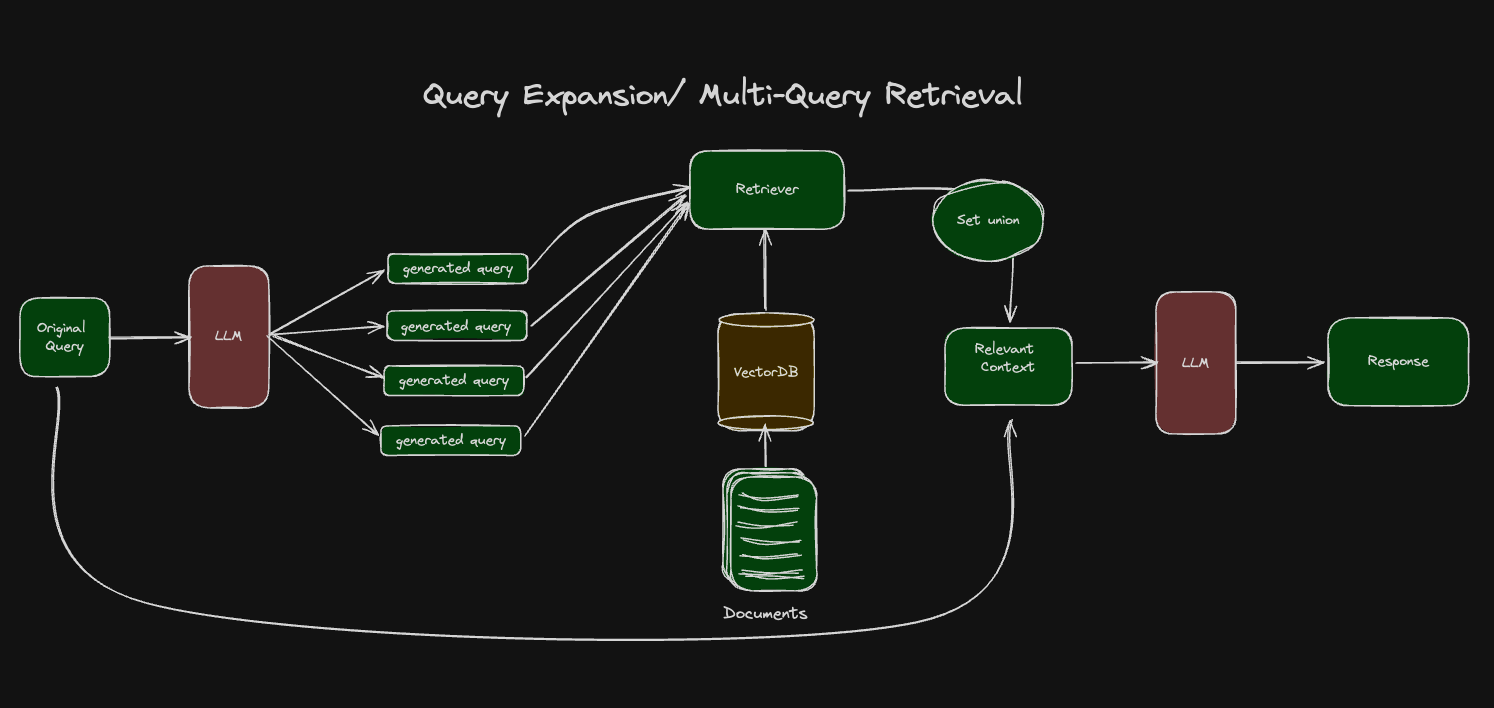

---

## 🔍 SECTION 3: QUERY EXPANSION - Multi-Query Retrieval

### The Problem with Single Queries

**User queries are often:**
- Ambiguous: "What's the revenue?" (which quarter? which product?)
- Incomplete: "expenses" (operational? capital? which year?)
- Poorly phrased: Different from how information is written in documents
- Too narrow: Might miss relevant information phrased differently

### Query Expansion Solution

**Concept:** Generate multiple related queries and retrieve for each

**Benefits:**
- Better coverage: Retrieve diverse perspectives
- Handle ambiguity: Multiple interpretations covered
- Reduce brittleness: Less sensitive to exact query phrasing
- Discover connections: Find related information not in original query

---

## SECTION 3: Query Expansion - Improving Query Understanding

**What You'll Learn:**
- Why queries sometimes fail to retrieve relevant documents
- How query expansion improves retrieval
- Multi-query retrieval technique

**The Problem:**
Users often phrase queries differently than documents are written:
- Query: "How do I train a model?"
- Document: "Model training process involves..."
- **Mismatch**: Different wording, same meaning

**What is Query Expansion?**
Query expansion generates **multiple variations** of the original query to increase the chances of finding relevant documents.

**Multi-Query Retrieval:**
1. Generate 3-5 query variations from the original query
2. Retrieve documents for each variation
3. Combine and deduplicate results
4. Return the union of all relevant chunks

**Benefits:**
- ✅ Handles different phrasings and synonyms
- ✅ Captures different perspectives on the query
- ✅ Improves recall (finds more relevant documents)
- ✅ Works well with semantic search

**Example:**
- Original: "What is instruction tuning?"
- Expanded:
  - "How does instruction tuning work?"
  - "Explain instruction tuning in machine learning"
  - "What is the process of instruction tuning?"

**When to Use:**
- ✅ Queries are ambiguous or could be phrased multiple ways
- ✅ Documents use different terminology than queries
- ✅ You want to maximize recall
- ❌ Very specific, unambiguous queries

- Query Decomposition
- Multi-query Retrieval

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question.
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation.
Generate multiple search queries related to: {question}
Output (5 queries):"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [ ]:
# Use IBM Granite LLM for query expansion
llm = ChatWatsonx(
    model_id='ibm/granite-3-2-8b-instruct',
    project_id=os.getenv("WATSONX_PROJECT_ID"),
    url=os.getenv("WATSONX_URL", "https://us-south.ml.cloud.ibm.com"),
    temperature=0.3
)


In [ ]:
query

"What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"

In [ ]:
# Chain
generate_queries_decomposition = ( decomposition_prompt | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
questions = generate_queries_decomposition.invoke({"question":query})

print(questions)

[
    '1. "What are the major operational costs for Airbnb in the last fiscal year?"',
    '2. "How has Airbnb\'s spending on customer support changed in the last year?"',
    '3. "What is the impact of regulatory compliance costs on Airbnb\'s operational expenses?"',
    '4. "How has Airbnb\'s investment in technology and infrastructure affected its operational costs?"',
    '5. "What role does marketing and advertising expenditure play in Airbnb\'s increased operational expenses?"'
]

### Multi-Query Retrieval

In [ ]:
from langchain_core.runnables import RunnablePassthrough, Runnable
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from typing import List, Any

# Custom Multi-Query Retriever Implementation
# (MultiQueryRetriever may not be available in some LangChain versions)
class MultiQueryRetriever(Runnable):
    """
    Custom implementation of multi-query retriever.
    Generates multiple query variations and retrieves documents for each.
    """
    def __init__(self, retriever, llm, num_queries=3):
        super().__init__()
        self.retriever = retriever
        self.llm = llm
        self.num_queries = num_queries

        # Prompt for generating query variations
        self.query_generation_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an AI language model assistant. Your task is to generate {num_queries} different versions of the given user question to retrieve relevant documents from a vector database. By generating multiple perspectives on the user question, your goal is to help the user overcome some of the limitations of distance-based semantic search. Provide these alternative questions separated by newlines."),
            ("human", "Original question: {question}")
        ])

    @property
    def InputType(self):
        """Input type for Runnable."""
        return str

    @property
    def OutputType(self):
        """Output type for Runnable."""
        from langchain_core.documents import Document
        return List[Any]

    @classmethod
    def from_llm(cls, retriever, llm, num_queries=3):
        """Create MultiQueryRetriever from a base retriever and LLM."""
        return cls(retriever, llm, num_queries)

    def _generate_queries(self, question: str) -> List[str]:
        """Generate multiple query variations."""
        chain = self.query_generation_prompt | self.llm | StrOutputParser()
        result = chain.invoke({
            "question": question,
            "num_queries": self.num_queries
        })

        # Parse the generated queries (split by newlines)
        queries = [q.strip() for q in result.split("\n") if q.strip()]

        # Always include the original question
        if question not in queries:
            queries.insert(0, question)

        # Limit to num_queries
        return queries[:self.num_queries]

    def invoke(self, input: Any, config: Any = None, **kwargs: Any):
        """Retrieve documents using multiple query variations.

        Accepts either a string query or a dict with 'question' or 'input' key.
        """
        # Extract query string from input
        if isinstance(input, dict):
            query = input.get("question", input.get("input", ""))
        else:
            query = str(input)

        # Generate query variations
        queries = self._generate_queries(query)

        # Retrieve documents for each query
        all_docs = []
        seen_docs = set()

        for q in queries:
            docs = self.retriever.invoke(q)
            for doc in docs:
                # Use content hash to deduplicate
                doc_hash = hash(doc.page_content)
                if doc_hash not in seen_docs:
                    seen_docs.add(doc_hash)
                    all_docs.append(doc)

        return all_docs

    def get_relevant_documents(self, query: str):
        """Compatibility method for older API."""
        return self.invoke(query)

# Create multi-query retriever
final_retriever = MultiQueryRetriever.from_llm(abnb_retriever, llm)

In [ ]:
prompt_template = """
You are a helpful assistant. Provide answers to users questions based on the provided context.

Context:
{context}

Question:
{question}


"""
prompt = ChatPromptTemplate.from_template(prompt_template)

# Create a lambda to extract query string for the retriever
from langchain_core.runnables import RunnableLambda

def get_query(input_dict):
    """Extract query from input dict or return string as-is."""
    if isinstance(input_dict, dict):
        return input_dict.get("question", input_dict.get("input", str(input_dict)))
    return str(input_dict)

# Create chain with proper query extraction
chain = {
    "question": RunnablePassthrough(),
    "context": RunnableLambda(get_query) | final_retriever
} | prompt | llm | StrOutputParser()

result = chain.invoke(query)

# display(HTML(result))
print(result)

The context does not provide specific details on the factors contributing to Airbnb's increased operational 
expenses in the last fiscal year. However, it does mention several categories of expenses:

1. **Cost of Revenue**: This includes payment processing charges, third-party data center costs, and amortization 
of internally developed software and acquired technology.

2. **Operations and Support**: These are personnel-related expenses and third-party service provider fees for 
customer support, customer relations costs (including refunds and credits), and expenses associated with Host 
protection programs.

3. **Product Development**: This includes personnel-related expenses and third-party service provider fees for 
developing and improving the platform and new products.

4. **Sales and Marketing**: This category includes performance and brand marketing, personnel-related expenses, 
referral incentives, policy and communications, and allocated costs for facilities and information technology. The 
advertising expenses specifically increased from $176.0 million in 2020 to $786.1 million in 2022.

5. **General and Administrative**: This encompasses personnel-related expenses for executive management and 
administrative functions, professional services fees, indirect taxes, and bad debt expense.

Without more specific information, it's not possible to pinpoint which of these categories or specific line items 
within them experienced the most significant increase in the last fiscal year. For detailed insights, one would 
need to refer to the company's annual report or other financial disclosures for that period.

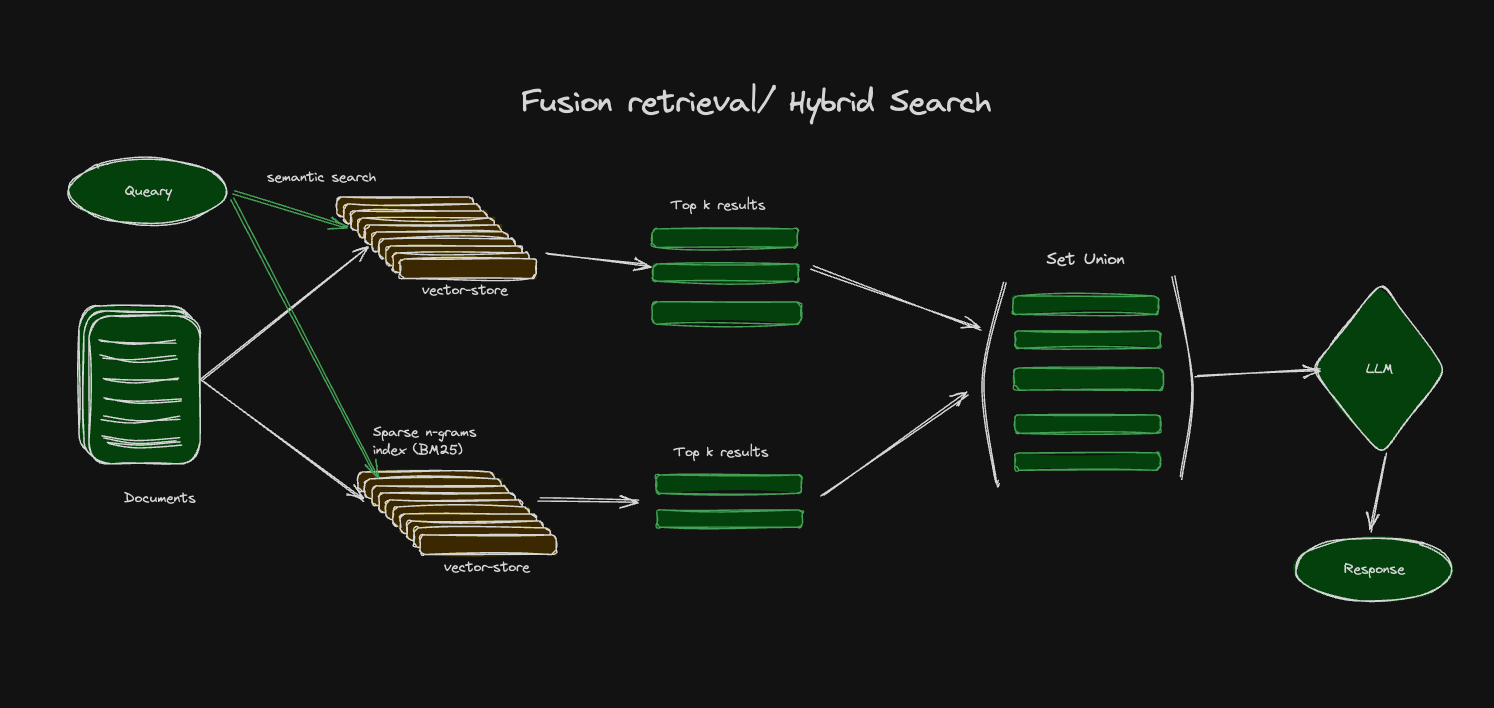

---

## 🔀 SECTION 4: FUSION RETRIEVER / HYBRID SEARCH

### Combining Semantic and Lexical Search

**Two Paradigms of Search:**

**1. Semantic Search (Vector/Embedding-based):**
- How: Converts text to vectors, uses cosine similarity
- Strengths: Understands meaning, handles synonyms, concepts
- Weaknesses: May miss exact keywords, proper nouns, acronyms

**2. Lexical Search (Keyword-based, BM25):**
- How: Counts term frequency, inverse document frequency
- Strengths: Exact matching, keywords, proper nouns
- Weaknesses: No semantic understanding, misses synonyms

### The Hybrid Approach

**Concept:** Use BOTH methods and combine results

**Advantages:**
- Best of both worlds: Semantic understanding + exact matching
- Better recall: Captures documents missed by either method alone
- Robust: Less sensitive to query formulation
- Handles diverse queries: Keywords, concepts, questions all work well

**When to Use:**
- Domain has important proper nouns (companies, people, products)
- Mix of keyword and semantic queries expected
- Need maximum recall

---



**What You'll Learn:**
- Why combining different search methods improves results
- Semantic vs keyword search trade-offs
- How to create ensemble retrievers

**The Problem:**
- **Semantic Search (Embeddings)**: Good at meaning, but may miss exact keywords
- **Keyword Search (BM25)**: Excellent at exact matches, but misses synonyms/paraphrases

**The Solution: Hybrid Search**
Combine both approaches to get the best of both worlds!

**How Hybrid Search Works:**
1. **Semantic Retrieval**: Use embeddings to find semantically similar chunks
2. **Keyword Retrieval**: Use BM25 to find chunks with matching keywords
3. **Fusion**: Combine results with weighted scores
4. **Rank**: Return top-k based on combined scores

**BM25 Explained:**
- Best Match 25 - classic information retrieval algorithm
- Based on term frequency (TF) and inverse document frequency (IDF)
- Great at exact keyword matching
- Fast and efficient

**Ensemble Strategy:**
```
Final Score = (weight1 × SemanticScore) + (weight2 × KeywordScore)
```

Typical weights:
- 0.5/0.5: Balanced approach
- 0.7/0.3: Favor semantic (better for conceptual queries)
- 0.3/0.7: Favor keyword (better for fact-finding queries)

**Benefits:**
- ✅ Combines strengths of both methods
- ✅ Handles both semantic and exact match queries
- ✅ More robust retrieval

**When to Use:**
- ✅ Mix of query types (some semantic, some keyword-based)
- ✅ Documents have both technical terms and natural language
- ✅ You want maximum retrieval quality

In [ ]:
from langchain_community.vectorstores import Chroma

def get_retriever(docs, embedding_model, collection_name="test", top_k=3) -> Any:
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs,
            embedding_model,
            collection_name=collection_name
        )

        retriever = vector_store.as_retriever(k=top_k)
        # retriever.k = top_k

        return retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise

In [ ]:

from langchain_community.retrievers.bm25 import BM25Retriever
from langchain_core.runnables import Runnable
from typing import List, Any
from collections import defaultdict

# Custom EnsembleRetriever Implementation
# (EnsembleRetriever may not be available in some LangChain versions)
class EnsembleRetriever(Runnable):
    """
    Custom implementation of ensemble retriever.
    Combines results from multiple retrievers with weighted scores.
    """
    def __init__(self, retrievers: List[Any], weights: List[float] = None):
        """
        Initialize ensemble retriever.

        Args:
            retrievers: List of retriever objects to combine
            weights: List of weights for each retriever (defaults to equal weights)
        """
        super().__init__()
        self.retrievers = retrievers

        if weights is None:
            weights = [1.0 / len(retrievers)] * len(retrievers)

        if len(weights) != len(retrievers):
            raise ValueError(f"Number of weights ({len(weights)}) must match number of retrievers ({len(retrievers)})")

        self.weights = weights

    @property
    def InputType(self):
        """Input type for Runnable."""
        return str

    @property
    def OutputType(self):
        """Output type for Runnable."""
        from langchain_core.documents import Document
        return List[Any]

    def invoke(self, input: Any, config: Any = None, **kwargs: Any):
        """Retrieve documents using ensemble of retrievers.

        Accepts either a string query or a dict with 'question' or 'input' key.
        """
        # Extract query string from input
        if isinstance(input, dict):
            query = input.get("question", input.get("input", ""))
        else:
            query = str(input)

        # Get documents from each retriever
        all_doc_scores = defaultdict(float)
        all_docs = {}

        for retriever, weight in zip(self.retrievers, self.weights):
            # Retrieve documents
            docs = retriever.invoke(query)

            # Assign scores based on rank (higher rank = higher score)
            # Documents are typically returned in order of relevance
            num_docs = len(docs)
            for rank, doc in enumerate(docs):
                # Use content hash as unique identifier
                doc_hash = hash(doc.page_content)

                # Calculate score: (num_docs - rank) / num_docs * weight
                # This gives higher scores to documents ranked higher
                if num_docs > 0:
                    score = ((num_docs - rank) / num_docs) * weight
                else:
                    score = weight

                # Store document if not seen before
                if doc_hash not in all_docs:
                    all_docs[doc_hash] = doc

                # Accumulate scores
                all_doc_scores[doc_hash] += score

        # Sort documents by combined score
        sorted_docs = sorted(
            all_docs.items(),
            key=lambda x: all_doc_scores[x[0]],
            reverse=True
        )

        # Return documents in order of combined scores
        return [doc for _, doc in sorted_docs]

    def get_relevant_documents(self, query: str):
        """Compatibility method for older API."""
        return self.invoke(query)


def get_ensemble_retriever(docs, embedding_model, collection_name="test", top_k=3) -> Any:
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """

    # Hybrid search
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs,
            embedding_model,
            collection_name=collection_name,
        )

        retriever = vector_store.as_retriever(search_kwargs={"k":top_k})
        # retriever.k = top_k

        # add keyword search
        keyword_retriever = BM25Retriever.from_documents(docs)
        keyword_retriever.k =  3

        ensemble_retriever = EnsembleRetriever(retrievers=[retriever,
                                                    keyword_retriever],
                                        weights=[0.5, 0.5])

        return ensemble_retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise


In [ ]:
hybrid_retriever = get_ensemble_retriever(docs, embedding_model, collection_name="hybrid_search", top_k=5)

In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"
similar_chunks = retrieve_context(
        query, retriever=hybrid_retriever,
    )

for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content[:500])

--------------------------------- chunk # 0 -------------------------------------

The Company generally collects funds related to bookings from guests on behalf of Hosts prior to check-in. However,
in limited circumstances the Company disburses funds to a Host or a guest on behalf of a counterparty guest or Host
prior to collecting such amounts from the counterparty. Such uncollected balances generally arise from the timing 
of payments and collections related to a dispute resolution between the guest and Host or certain alterations to 
stays and are included in prepaids and ot

--------------------------------- chunk # 1 -------------------------------------

- operational and compliance challenges caused by distance, language, and cultural differences;
- the cost and resources required to localize our platform and services, which often requires the translation of 
our platform into foreign languages and adaptation for local practices and regulatory requirements;
- unexpected, more restrictive, differing, and conflicting laws and regulations, including those laws governing 
Internet activities, short-term and long-term rentals (including those implemen

--------------------------------- chunk # 2 -------------------------------------

|                                                                                                                  
| Year Ended December 31,   | Year Ended December 31,   | Year Ended December 31,   |
|------------------------------------------------------------------------------------------------------------------
----|---------------------------|---------------------------|---------------------------|
|

--------------------------------- chunk # 3 -------------------------------------

Codification 470-20 (or any other Accounting Standards Codification having a similar result or effect) (and related
interpretations) to value any such Indebtedness in a reduced or bifurcated manner as described therein, and such 
Indebtedness shall at all times be valued at the full stated principal amount thereof, and (C) without giving 
effect to any change in accounting for leases resulting from the implementation of Financial Accounting Standards 
Board ASU No. 2016-02, Leases (Topic 842), to t

--------------------------------- chunk # 4 -------------------------------------

|                                                                                                      | Page   |
|------------------------------------------------------------------------------------------------------|--------|
| Report of Independent Registered Public Accounting Firm (PCAOB ID 238)                               | 67     |
| Consolidated Financial Statements                                                                    |        |
| Consolidated Balance Sheets

--------------------------------- chunk # 5 -------------------------------------

An individual who served as an executive officer of the Company through March 1, 2020, also served as a director of
a payment processing vendor. The Company is party to a merchant agreement with the vendor whereby the Company earns
transaction fees and incentives for offering its services to its customers in certain markets and satisfying 
certain base requirements pursuant to the agreement. The Company applies the transaction fees and incentives 
received to partially offset the merchant fees cha

--------------------------------- chunk # 6 -------------------------------------

'Initial Delivery Date'); provided that the Pricing Certificate for any fiscal year may be delivered on any date 
following the Initial Delivery Date that is prior to the date that is 365 days following the last day of the 
preceding fiscal year, so long as such Pricing Certificate includes a certification that delivery of such Pricing 
Certificate on or before the Initial Delivery Date was not possible because (i) the information required to 
calculate the KPI Metrics for such preceding fiscal year

--------------------------------- chunk # 7 -------------------------------------

## Airbnb, Inc.

## Notes to Consolidated Financial Statements

The Company has elected to exclude from revenue, taxes assessed by a governmental authority that are both imposed 
on and are concurrent with specific revenue producing transactions. Accordingly, such amounts are not included as a
component of revenue or cost of revenue.

## Payments to Customers

The Company makes payments to customers as part of its referral programs and marketing promotions, collectively 
referred to as the Company

In [ ]:
prompt_template = """
You are a helpful assistant. Provide answers to users questions based on the provided context.

Context:
{context}

Question:
{question}


"""
prompt = ChatPromptTemplate.from_template(prompt_template)

chain = {"question": RunnablePassthrough(), "context": hybrid_retriever} \
        | prompt \
        | llm \
        | StrOutputParser() \

result = chain.invoke(query)

# display(HTML(result))
print(result)

The document does not provide specific details on the factors contributing to Airbnb's increased operational 
expenses in the last fiscal year. However, it does mention several general factors that could potentially 
contribute to increased operational expenses in international operations:

1. Operational and compliance challenges caused by distance, language, and cultural differences.
2. The cost and resources required to localize the platform and services, including translation and adaptation for 
local practices and regulatory requirements.
3. Unexpected, more restrictive, differing, and conflicting laws and regulations, including those related to 
Internet activities, short-term and long-term rentals, tourism, tenancy, taxes, licensing, payments processing, 
messaging, marketing activities, registration and verification of guests, ownership of intellectual property, 
content, data collection and privacy, security, data localization, data transfer, and government access to personal
information.
4. Uncertainties regarding the interpretation of national and local laws and regulations, uncertainty in the 
enforceability of legal rights, and uneven application of laws and regulations to businesses, particularly U.S. 
companies.
5. Competition with companies that understand local markets better or have a local presence and pre-existing 
relationships with potential Hosts and guests.
6. Differing levels of social acceptance of home sharing, the Airbnb brand, and offerings.
7. Legal uncertainty regarding liability for listings, services, and content provided by Hosts, guests, and third 
parties.
8. Uncertain resolutions of litigation or regulatory inquiries.
9. Variations in payment forms for Hosts and guests, increased operational complexity around payments, and 
inability to offer local payment forms like cash or country-specific digital forms of payment.
10. Lack of familiarity and the burden of complying with a wide variety of U.S. and foreign laws, legal standards, 
and regulatory requirements.
11. Potentially adverse tax consequences, including resulting from the complexities of foreign corporate income tax
systems, VAT regimes, tax withholding rules, lodging taxes, hotel taxes, and other indirect taxes, tax collection 
or remittance obligations, and restrictions on the repatriation of earnings.
12. Difficulties in managing and staffing international operations, including due to differences in legal, 
regulatory, and collective bargaining processes.
13. Fluctuations in currency exchange rates, particularly decreases in the value of foreign currencies relative to 
the U.S. dollar.
14. Regulations governing the control of local currencies and impacting the ability to collect and remit funds to 
Hosts in those currencies or to repatriate cash into the United States.
15. Oversight by foreign government agencies whose approach to privacy or human rights may be inconsistent with 
that taken in other countries.
16. Increased financial accounting and reporting burdens, and complexities and difficulties in implementing and 
maintaining adequate internal controls in an international operating environment.
17. Political, social, and economic instability abroad, terrorist attacks, and security concerns in general.
18. Operating in countries that are more prone to crime or have lower safety standards.
19. Operating in countries that have higher risk of corruption.
20. Reduced or varied protection for intellectual property rights in some countries.

For a precise breakdown of the increased operational expenses in the last fiscal year, one would need to refer to 
Airbnb's annual report or other financial disclosures for that period.

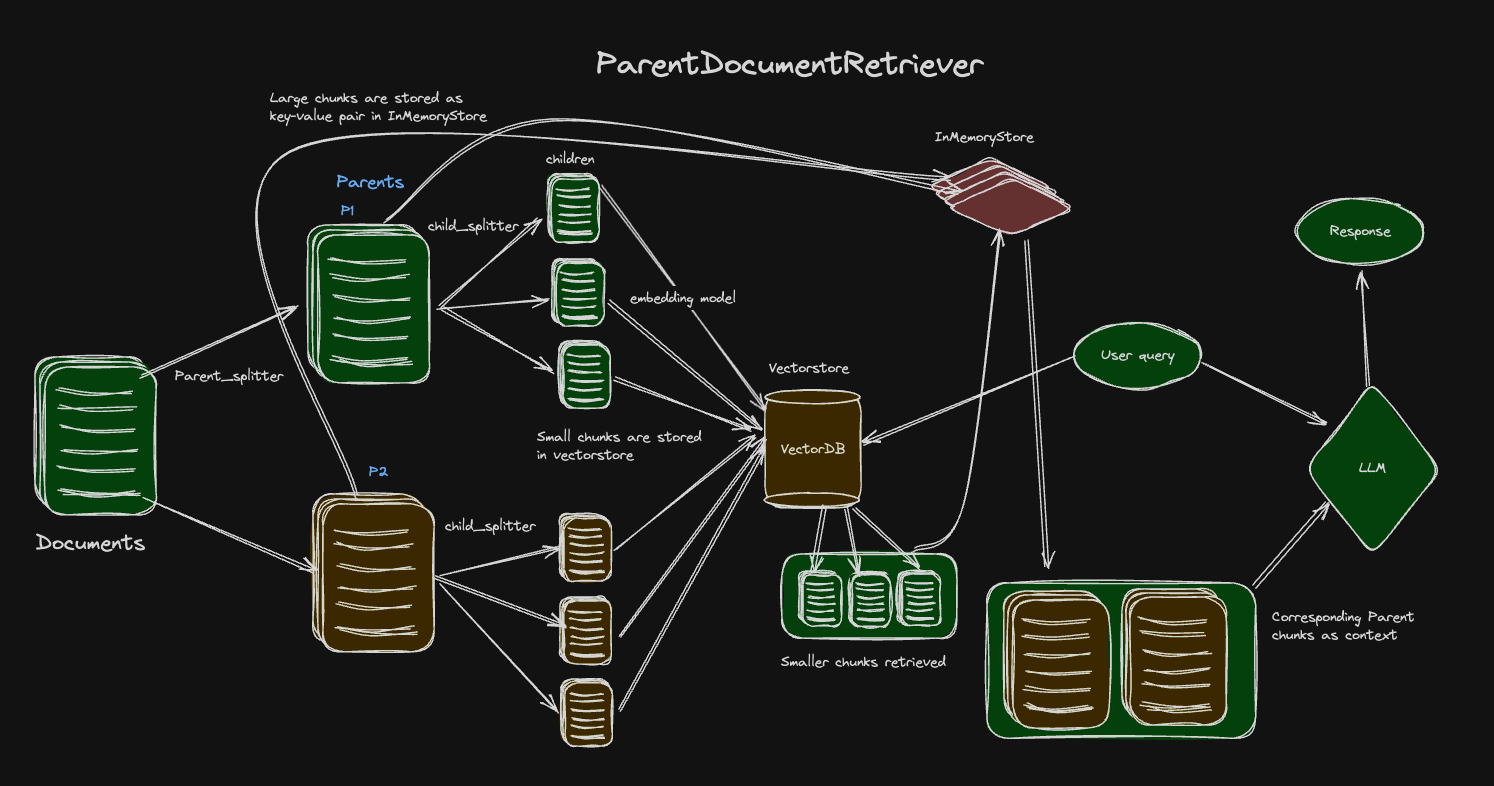

---

## 📄 SECTION 5: PARENT DOCUMENT RETRIEVER - Context Expansion

### The Chunking Dilemma

**The Trade-off:**
- Small chunks: Precise retrieval but lack context
- Large chunks: More context but less precise

### Parent Document Retriever Solution

**Brilliant Idea:**
1. Index: Small chunks (for precise retrieval)
2. Retrieve: Small chunks (high precision)
3. Return: Larger "parent" documents (full context)

**Benefits:**
- Best of both worlds: Precise retrieval + full context
- Better LLM responses: More complete information
- Reduced hallucination: LLM has full context to work with

**Perfect for:**
- Long-form content: Research papers, legal documents, books
- Structured documents: Documents with clear sections/subsections
- Complex queries: Queries requiring broader context

---


**What You'll Learn:**
- The precision vs context trade-off in retrieval
- How parent document retrieval solves this
- Two-stage chunking strategy

**The Problem:**
- **Small Chunks**: Precise retrieval, but may lack context
- **Large Chunks**: More context, but may include irrelevant information

**Example:**
- Query: "What are the training steps?"
- Small chunk (precise match): "The training steps are: 1) Initialize..."
- But this chunk is missing context: What model? What dataset? What's the goal?

**Parent Document Retriever Solution:**
1. **Index with small chunks** (for precise retrieval)
2. **Store parent documents** (larger chunks) separately
3. **Retrieve small chunks** (precise matching)
4. **Return parent documents** (full context)

**How It Works:**
- **Child Chunks**: Small (e.g., 200 chars) - used for embedding/indexing
- **Parent Documents**: Large (e.g., 2000 chars) - stored separately
- **Linkage**: Each child chunk references its parent document
- **Retrieval**: Find child chunks → return their parent documents

**Benefits:**
- ✅ Precise retrieval (small chunks find exact matches)
- ✅ Full context (parent documents provide surrounding information)
- ✅ Best of both worlds

**Use Cases:**
- ✅ Technical documentation (need both specific details and context)
- ✅ Academic papers (sections need paper context)
- ✅ Legal documents (clauses need document context)
- ✅ Code documentation (functions need file/class context)

**Trade-offs:**
- ❌ More complex indexing
- ❌ Requires storing both child and parent
- ❌ Slightly slower retrieval

In [ ]:
def get_retriever(docs, embedding_model, top_k=3) -> Any:
    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """
    # Example of parameter validation (optional)
    if top_k < 1:
        raise ValueError("top_k must be at least 1")

    try:
        vector_store = Chroma.from_documents(
            docs, embedding_model,
        )

        retriever = vector_store.as_retriever(k=top_k)
        # retriever.k = top_k

        return retriever
    except Exception as e:
        print(f"An error occurred while initializing the retriever: {e}")
        raise


In [ ]:
from langchain_core.runnables import Runnable
from langchain_core.documents import Document
from typing import Dict, List, Any, Optional
from collections import defaultdict

# Custom InMemoryStore Implementation
# (InMemoryStore may not be available in some LangChain versions)
class InMemoryStore:
    """
    Simple in-memory document store for ParentDocumentRetriever.
    Stores documents keyed by their IDs.
    """
    def __init__(self):
        self.store: Dict[str, Document] = {}

    def mget(self, keys: List[str]) -> List[Optional[Document]]:
        """Get multiple documents by keys."""
        return [self.store.get(key) for key in keys]

    def mset(self, key_value_pairs: List[tuple]) -> None:
        """Set multiple key-value pairs."""
        for key, value in key_value_pairs:
            self.store[key] = value

    def mdelete(self, keys: List[str]) -> None:
        """Delete multiple keys."""
        for key in keys:
            self.store.pop(key, None)

    def yield_keys(self, prefix: Optional[str] = None) -> List[str]:
        """Yield keys, optionally filtered by prefix."""
        if prefix:
            return [key for key in self.store.keys() if key.startswith(prefix)]
        return list(self.store.keys())

# Custom ParentDocumentRetriever Implementation
# (ParentDocumentRetriever may not be available in some LangChain versions)
class ParentDocumentRetriever(Runnable):
    """
    Retriever that returns parent documents instead of child chunks.

    Concept:
    - Splits documents into small "child" chunks for indexing (precise retrieval)
    - Stores larger "parent" documents separately
    - When retrieving: finds small chunks → returns parent documents (full context)
    """
    def __init__(
        self,
        vectorstore,
        docstore: InMemoryStore,
        child_splitter,
        parent_splitter,
        k: int = 4,
        search_kwargs: Optional[Dict] = None
    ):
        super().__init__()
        self.vectorstore = vectorstore
        self.docstore = docstore
        self.child_splitter = child_splitter
        self.parent_splitter = parent_splitter
        self.k = k
        self.search_kwargs = search_kwargs or {}

    @property
    def InputType(self):
        """Input type for Runnable."""
        return str

    @property
    def OutputType(self):
        """Output type for Runnable."""
        return List[Document]

    def add_documents(self, documents: List[Document]) -> None:
        """Add documents to the retriever.

        Process:
        1. Split into parent documents
        2. For each parent, split into child chunks
        3. Store parents in docstore
        4. Index child chunks in vectorstore (with reference to parent)
        """
        parent_docs = self.parent_splitter.split_documents(documents)

        for parent_doc in parent_docs:
            # Create unique ID for parent
            parent_id = f"parent_{hash(parent_doc.page_content)}"

            # Store parent in docstore
            self.docstore.mset([(parent_id, parent_doc)])

            # Split parent into child chunks
            child_docs = self.child_splitter.split_documents([parent_doc])

            # Add parent_id to child metadata
            for child_doc in child_docs:
                if child_doc.metadata is None:
                    child_doc.metadata = {}
                child_doc.metadata["parent_id"] = parent_id

            # Add child chunks to vectorstore
            if child_docs:
                self.vectorstore.add_documents(child_docs)

    def invoke(self, input: Any, config: Any = None, **kwargs: Any) -> List[Document]:
        """Retrieve parent documents for a query.

        Process:
        1. Query vectorstore with child chunks
        2. Extract parent_id from child chunks
        3. Retrieve parent documents from docstore
        4. Return unique parent documents
        """
        # Extract query string
        if isinstance(input, dict):
            query = input.get("question", input.get("input", ""))
        else:
            query = str(input)

        # Search in vectorstore (gets child chunks)
        search_kwargs = {**self.search_kwargs, "k": self.k}
        child_docs = self.vectorstore.similarity_search(query, **search_kwargs)

        # Get unique parent IDs
        parent_ids = set()
        for child_doc in child_docs:
            parent_id = child_doc.metadata.get("parent_id")
            if parent_id:
                parent_ids.add(parent_id)

        # Retrieve parent documents
        parent_docs = self.docstore.mget(list(parent_ids))

        # Filter out None values and return
        return [doc for doc in parent_docs if doc is not None]

    def get_relevant_documents(self, query: str) -> List[Document]:
        """Compatibility method for older API."""
        return self.invoke(query)


def create_parent_retriever(
    docs,
    embeddings_model,
    collection_name="split_documents",
    top_k=5,
    persist_directory=None,
):

    """
    Initializes a retriever object to fetch the top_k most relevant documents based on cosine similarity.

    Parameters:
    - docs: A list of documents to be indexed and retrieved.
    - embedding_model: The embedding model to use for generating document embeddings.
    - collection_name: The name of the collection
    - top_k: The number of top relevant documents to retrieve. Defaults to 3.
    - persist_directory: directory where you want to store your vectorDB

    Returns:
    - A retriever object configured to retrieve the top_k relevant documents.

    Raises:
    - ValueError: If any input parameter is invalid.
    """

    from langchain_text_splitters import RecursiveCharacterTextSplitter

    parent_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        separators=["\n\n\n", "\n\n", "\n", ".", ""],
        chunk_size=512,
        chunk_overlap=0,
        model_name="gpt-4",
        is_separator_regex=False,
    )

    # This text splitter is used to create the child documents
    child_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        separators=["\n\n\n", "\n\n", "\n", ".", ""],
        chunk_size=256,
        chunk_overlap=0,
        model_name="gpt-4",
        is_separator_regex=False,
    )

    # The vectorstore to use to index the child chunks
    vectorstore = Chroma(
        collection_name=collection_name,
        embedding_function=embeddings_model,
        persist_directory=persist_directory,
    )

    # The storage layer for the parent documents
    store = InMemoryStore()
    retriever = ParentDocumentRetriever(
        vectorstore=vectorstore,
        docstore=store,
        child_splitter=child_splitter,
        parent_splitter=parent_splitter,
        k=10,
    )
    retriever.add_documents(docs)


    return retriever, vectorstore.as_retriever()

In [ ]:
#documents = load_pdf_docling("./data/8a9ebed0-815a-469a-87eb-1767d21d8cec.pdf")

In [ ]:
parent_retriever, child_retriever = create_parent_retriever(documents, embedding_model, collection_name="parent_child_split-1")

/tmp/ipython-input-3436502364.py:187: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [ ]:
query = "What are the specific factors contributing to Airbnb's increased operational expenses in the last fiscal year?"

In [ ]:
similar_chunks = retrieve_context(
        query, retriever=child_retriever,
    )
for i, chunks in enumerate(similar_chunks):
    print(f"--------------------------------- chunk # {i} -------------------------------------")
    print(chunks.page_content)

--------------------------------- chunk # 0 -------------------------------------

## Airbnb, Inc.

## Notes to Consolidated Financial Statements

For the year ended December 31, 2021, the increase in the Company's valuation allowance compared to the prior year 
was primarily due to the 2021 net operating loss, an increase in tax credits generated, and business interest 
expenses subject to limitation. For the year ended December 31, 2022, the decrease in the Company's valuation 
allowance compared to the prior year was primarily due to the utilization of net operating losses, business 
interest deductions subject to limitation in prior years, and stock-based compensation deductions, partially offset
by capitalized research and development costs under Section 174.

--------------------------------- chunk # 1 -------------------------------------

Net expense with this vendor was $210.9 million for the year ended December 31, 2020, and was included in cost of 
revenue in the consolidated statements of operations.

## Airbnb, Inc.

## Notes to Consolidated Financial Statements

## Airbnb, Inc.

## Schedule II-Valuation and Qualifying Accounts

The tables below detail the activity of the customer receivable reserve, insurance liability, and the valuation 
allowance on deferred tax assets for the years ended December 31, 2020, 2021, and 2022 (in millions):

--------------------------------- chunk # 2 -------------------------------------

General and administrative expense increased $114.0 million, or 14%, in 2022 compared to 2021, primarily due to an 
increase in other business and operational taxes of $41.3 million, a $25.5 million increase in professional 
services expenses, primarily due to third-party service provider expenses, a $21.7 million increase in bad debt 
expenses, a $6.2 million increase in travel and entertainment expenses, and a $6.0 million increase in charitable 
contributions to Airbnb.org, primarily to support Ukrainian refugees.

## Restructuring Charges

|                       | 2021                              | 2022                              | %Change          
|
|-----------------------|-----------------------------------|-----------------------------------|------------------
-----------------|
|                       | (in millions, except percentages) | (in millions, except percentages) | (in millions, 
except percentages) |
| Restructuring charges | $                                 | 113 $                             | (21)%            
|
| Percentage of revenue |                                   | 2%                                |                  
|

--------------------------------- chunk # 3 -------------------------------------

|                      | Total   | Less than 1 year   | 1 to 3 years   | 3 to 5 years   | More than 5 years   |
|----------------------|---------|--------------------|----------------|----------------|---------------------|
| Purchase obligations | 1,068 $ | 137 $              | 517 $          | 414 $          | -                   |
| Other commitments    | 232     | 37                 | 76             | 79             | 40                  |
| Total                | 1,300 $ | 174 $              | 593 $          | 493 $          | 40                  |

Purchase commitments include amounts related to the Company's commercial agreement with a data hosting services 
provider, pursuant to which the Company committed to spend an aggregate of at least $941.7 million for vendor 
services through 2027.

## Extenuating Circumstances Policy

In March 2020, the Company applied its extenuating circumstances policy to cancellations resulting from COVID-19. 
That policy provides

## Airbnb, Inc.

## Notes to Consolidated Financial Statements

In [ ]:
prompt_template = """
You are a helpful assistant. Provide answers to users questions based on the provided context.

Context:
{context}

Question:
{question}


"""
prompt = ChatPromptTemplate.from_template(prompt_template)

chain = {"question": RunnablePassthrough(), "context": parent_retriever} \
        | prompt \
        | llm \
        | StrOutputParser() \

result = chain.invoke(query)

# display(HTML(result))
print(result)

Airbnb's operational expenses increased in the last fiscal year due to several factors:

1. Sales and Marketing Expense: There was a $329.9 million, or 28%, increase in sales and marketing expenses in 
2022 compared to 2021. This increase was primarily due to higher marketing activities associated with various 
campaigns and launches, increased search engine marketing and advertising spend, higher payroll-related expenses 
due to growth in headcount and increased compensation costs, increased third-party service provider expenses, and 
higher coupon expenses.

2. General and Administrative Expense: General and administrative expenses rose by $114.0 million, or 14%, in 2022 
compared to 2021. This increase was mainly due to higher other business and operational taxes, increased 
professional services expenses (especially third-party service provider expenses), higher bad debt expenses, 
increased travel and entertainment expenses, and more charitable contributions to Airbnb.org, primarily to support 
Ukrainian refugees.

3. Restructuring Charges: Although restructuring charges decreased by $23.7 million, or 21%, in 2022 compared to 
2021, the shift to a remote work model due to COVID-19 led to an impairment of both domestic and international 
operating lease right-of-use ('ROU') assets and related leasehold improvements, contributing to the restructuring 
charges in 2022.

4. Interest Income and Expense: Interest income increased significantly by 1,361% in 2022 compared to 2021, 
contributing to the overall expenses. However, interest expense decreased by 95%, which positively impacted the net
expenses.

These factors combined led to the overall increase in operational expenses for Airbnb in the last fiscal year.